# import statements

In [1]:
from __future__ import division
from collections import Counter
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.cluster.bicluster import SpectralBiclustering

import pandas as pd
import pylab as plt
import numpy as np
import pprint
import seaborn
import pylab
import random
import itertools

%matplotlib inline

In [2]:
folder = '../data/'

#Trypsin datafiles
protein = 'ALL_WP_trypsin_protein.xlsx'
glycopeptide = 'df_reference_glycan_trypsin_ALL.xlsx'
glycoprotein = 'ALL_GP_trypsin_sequest_protein.xlsx'
chartpattern = 'ALL_glycan_trypsin_chartpattern.xlsx'

#Chymotrypsin datafiles
protein_chymo = 'ALL_WP_chymo_protein.xlsx'
glycopeptide_chymo = 'df_reference_glycan_chymo.xlsx'
glycoprotein_chymo = 'ALL_GP_chymo_sequest_protein.xlsx'
chartpattern_chymo = 'ALL_glycan_chymo_chartpattern.xlsx'

glycopeptide_trypsin_chymo = 'df_reference_glycan_trypsin_chymo.xlsx'

In [3]:
dfwp = pd.read_excel((folder + protein), sheetname='Sheet1')
dfgp = pd.read_excel((folder + glycoprotein), sheetname='Sheet1')
dfg = pd.read_excel((folder + glycopeptide), sheetname='Sheet1')
cp = pd.read_excel((folder + chartpattern), sheetname='Sheet1' )

FileNotFoundError: [Errno 2] No such file or directory: '../data/ALL_WP_trypsin_protein.xlsx'

In [ ]:
dfwp_chymo = pd.read_excel((folder + protein_chymo), sheetname='Sheet1')
dfgp_chymo = pd.read_excel((folder + glycoprotein_chymo), sheetname='Sheet1')
dfg_chymo = pd.read_excel((folder + glycopeptide_chymo), sheetname='Sheet1')
cp_chymo = pd.read_excel((folder + chartpattern_chymo), sheetname='Sheet1' )

In [7]:
### WHOLE PROTEIN LEVEL ANALYSIS - TRYPSIN ###

# data transformations

In [8]:
def strip_non_ascii(string):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in string if 47 < ord(c) < 127)
    return ''.join(stripped)

def normalize(df, col_to_normalize, min_number=2):
    # make all column names lower case for consistency
    df.columns = [strip_non_ascii(x) for x in df.columns]
    df.columns = df.columns.str.lower()

    #The excel file contains multiple rows of the same accession. These rows should be summed together

    df0 = df.groupby('accession', as_index=False).sum()

    #filtering by Σ# PSMs 
    df0 = df0[df0['psms'] > min_number]

    normalized = (df0[col_to_normalize]
             .replace(0, np.NaN)
             .apply(np.log) # transform non-linear data
             .apply(lambda x: (x - x.mean())/x.std())) #Standard Normalization Method, Centers mean around 0 and STD = 1

    return  pd.concat([df0.accession, normalized], 1)

In [9]:
to_normalize = ['341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328',
                        '343_pmai','342_unlabel','155_iso','155_anti328','155_pmai','15m_iso','15m_anti','6h_iso','6h_anti',
                        '18h_iso','18h_anti']
dfwp1 = normalize(dfwp, to_normalize)

# first view at clustering

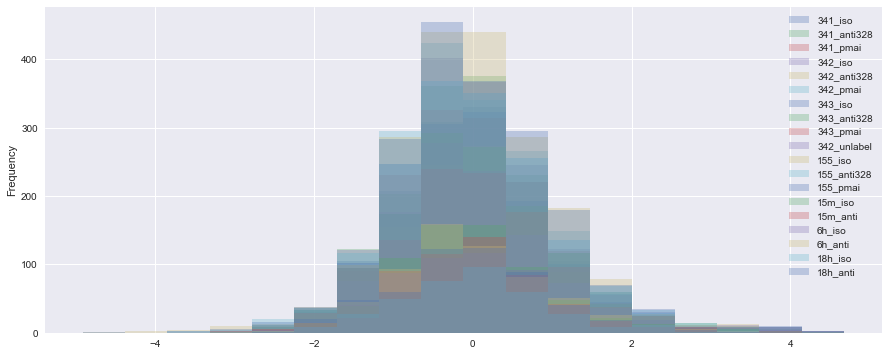

In [10]:
dfwp1.iloc[1:].plot.hist(alpha=.3, figsize=(15,6), bins=18)

In [11]:
km = KMeans(n_clusters=5)

X = dfwp1.set_index("accession").T.fillna(0)

X_subset = X.iloc[0:10,:]
X_subset_timecourse = X.iloc[13:20,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)

In [12]:
#hierarchical clustering

hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [13]:
#spectral clustering
bi = SpectralBiclustering()
bi.fit(X_subset)
bi.get_indices(2);

In [14]:
#dbscan
db = DBSCAN()
db_predict = db.fit_predict(X)

In [15]:
output = pd.DataFrame({'kmeans': km_predict, 'hierarchical':hc_predict})
output.index =X.index
output.head()

output_subset = pd.DataFrame({'kmeans': kms_predict, 'hierarchical':hcs_predict})
output_subset.index = X_subset.index
output_subset.head()

,hierarchical,kmeans
341_iso,0,2
341_anti328,0,2
341_pmai,3,0
342_iso,1,3
342_anti328,2,1


In [16]:
new_columns = ['341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328','343_pmai','342_unlabel']
new_columns1 = ['15m_iso','15m_anti','6h_iso','6h_anti']

In [17]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[0 0 3 1 2 1 3 2 2 3]
[ 7  5 16 ...,  5 16 16]


In [18]:
#X_subset['replicate_cluster'] = list(hcs_predict)

#transpose to sort by accession clusters
X_subset = X_subset.T
X_subset['accession_cluster'] = hcs_rows_predict

In [19]:
cluster_mean = X_subset.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [20]:
X_subset = X_subset.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

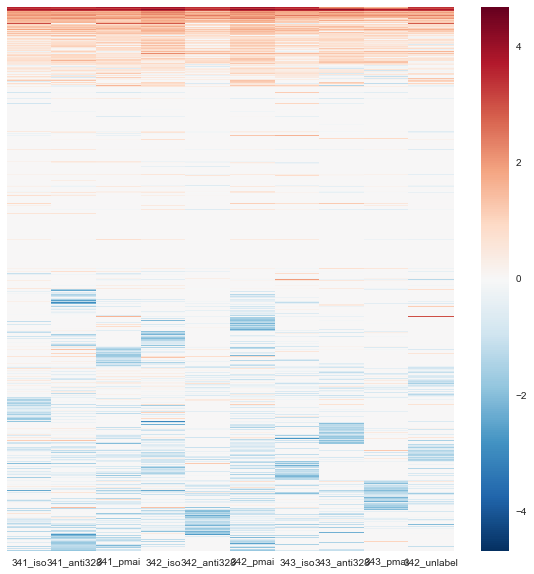

In [21]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset, xticklabels=True, yticklabels=False)

In [22]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfwp2 = dfwp1.fillna(0)


dfwp2['341_anti328_div_iso'] =  dfwp2['341_anti328'] - dfwp2['341_iso']
dfwp2['341_pmai_div_iso'] = dfwp2['341_pmai'] - dfwp2['341_iso']
dfwp2['342_anti328_div_iso'] =  dfwp2['342_anti328'] - dfwp2['342_iso']
dfwp2['342_pmai_div_iso'] = dfwp2['342_pmai'] - dfwp2['342_iso']
dfwp2['343_anti328_div_iso'] =  dfwp2['343_anti328'] - dfwp2['343_iso']
dfwp2['343_pmai_div_iso'] = dfwp2['343_pmai'] - dfwp2['343_iso']
dfwp2['155_anti328_div_iso'] =  dfwp2['155_anti328'] - dfwp2['155_iso']
dfwp2['155_pmai_div_iso'] = dfwp2['155_pmai'] - dfwp2['155_iso']
dfwp2['15m_anti328_div_iso'] =  dfwp2['15m_anti'] - dfwp2['15m_iso']
dfwp2['6h_anti328_div_iso'] =  dfwp2['6h_anti'] - dfwp2['6h_iso']
dfwp2['18h_anti328_div_iso'] =  dfwp2['18h_anti'] - dfwp2['18h_iso']


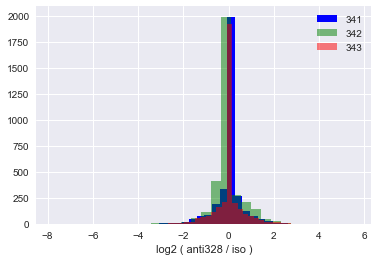

In [23]:
#ratio between anti and control
dfwp2['341_anti328_div_iso'].hist(bins=30, alpha = 1, color = 'b', label = '341')
dfwp2['342_anti328_div_iso'].hist(bins=30, alpha = 0.5, color = 'g', label = '342')
dfwp2['343_anti328_div_iso'].hist(bins=30, alpha = 0.5, color = 'r', label = '343')
#dfwp2['155_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'orange', label = '155')
#dfwp2['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
#dfwp2['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
#dfwp2['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

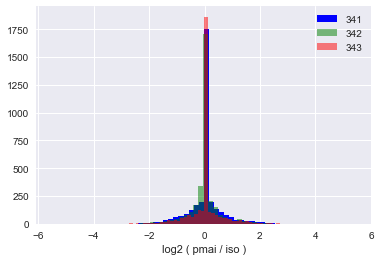

In [24]:
#ratio between pmai and control
dfwp2['341_pmai_div_iso'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfwp2['342_pmai_div_iso'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfwp2['343_pmai_div_iso'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
#dfwp2['155_pmai_div_iso'].hist(bins=60, alpha = 0.5, color = 'orange', label = '155')
plt.xlabel('log2 ( pmai / iso )')
plt.legend()

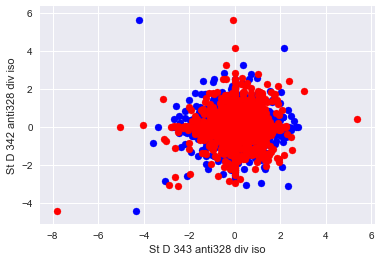

In [25]:
plt.scatter(dfwp2['343_anti328_div_iso'], dfwp2['341_anti328_div_iso'], color = 'b')
plt.scatter(dfwp2['342_anti328_div_iso'], dfwp2['341_anti328_div_iso'], color = 'r')
#plt.scatter(dfwp2['341_anti328_div_iso'], dfwp2['155_anti328_div_iso'], color = 'g')
plt.xlabel('St D 343 anti328 div iso')
plt.ylabel('St D 342 anti328 div iso')

In [26]:
X = dfwp2.set_index("accession").T.fillna(0)
X_subset = X.iloc[19:25,:]
X_subset_timecourse = X.iloc[27:30,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [27]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=3)
hcs_predict = hcs.fit_predict(X_subset)

In [28]:
hcs_rows = AgglomerativeClustering(n_clusters=10)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [29]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[0 0 2 2 1 1]
[5 4 6 ..., 4 6 6]


In [30]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

#transpose to sort by accession clusters
X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

X_subset_ordered = X_subset_ordered.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

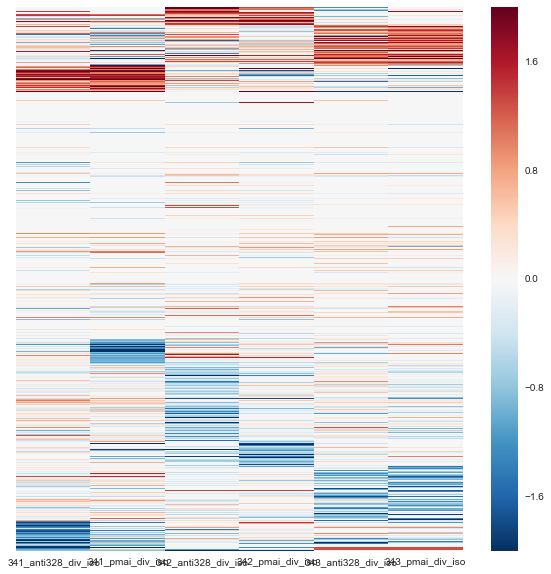

In [31]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered, vmin = -2, vmax = 2, xticklabels=True, yticklabels=False)

In [32]:
### Whole protein analysis -- chymotrypsin ###

In [33]:
col_to_normalize = ['341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328',
                        '343_pmai','342_unlabel','15min_iso','15m_anti','6h_iso','6h_anti','18h_iso','18h_anti']
dfwp1_chymo = normalize(dfwp_chymo, col_to_normalize)

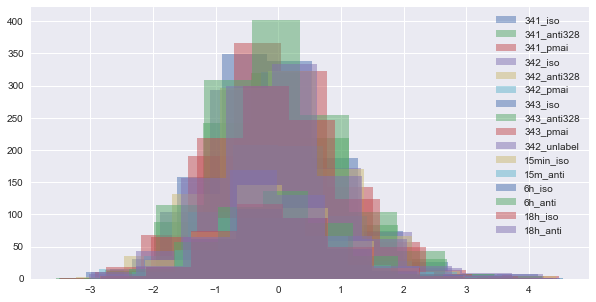

In [34]:
plt.figure(figsize=(10,5))
for col in dfwp1_chymo.columns[1:]:
    dfwp1_chymo[col].hist(label=col, alpha=.5)
plt.legend()


In [35]:
X_chymo = dfwp1_chymo.set_index("accession").T.fillna(0)
X_subset_chymo = X_chymo.iloc[0:10,:]
km_predict = km.fit_predict(X_chymo)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset_chymo)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [36]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X_chymo)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset_chymo)

In [37]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset_chymo.T)

In [38]:
X_subset_chymo.T.columns
new_columns_chymo = [ '341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328','343_pmai','342_unlabel']

In [39]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[0 2 2 2 2 1 1 0 0 3]
[18  8  9 ...,  9  2  4]


In [40]:
X_subset_chymo['replicate_cluster'] = hcs_predict

/Users/ahuang/virtualenvs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [41]:
#sort by replicate clusters
X_subset_ordered_chymo = X_subset_chymo.copy()
X_subset_ordered_chymo['replicate_cluster'] = hcs_predict
X_subset_ordered_chymo = X_subset_ordered_chymo.iloc[:,:-1]

In [42]:
#transpose to sort by accession clusters
X_subset_ordered_chymo = X_subset_ordered_chymo.T
X_subset_ordered_chymo['accession_cluster'] = hcs_rows_predict
#X_subset_ordered['accession_cluster_mean'] = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)

#assigned each accession to a cluster. then sort clusters by sum of replicate means

#X_subset_ordered = X_subset_ordered.sort_values('accession_cluster_mean').iloc[:,:-2]

In [43]:
cluster_mean = X_subset_ordered_chymo.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [44]:
X_subset_ordered_chymo = X_subset_ordered_chymo.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

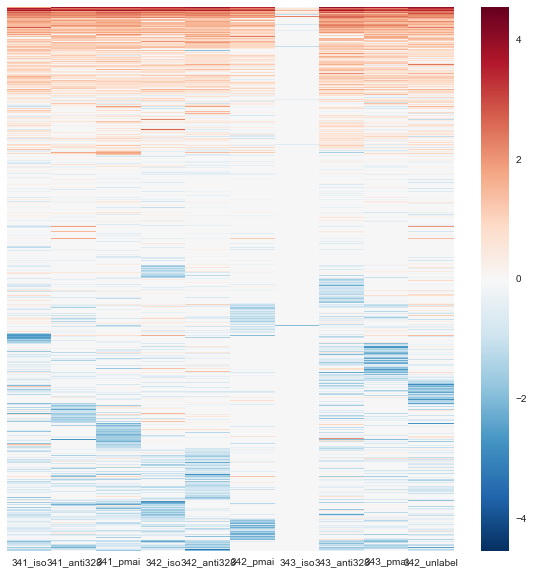

In [45]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered_chymo, xticklabels=True, yticklabels=False)

In [46]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfwp2_chymo = dfwp1_chymo.fillna(0)
dfwp2_chymo['341_anti328_div_iso'] =  dfwp2_chymo['341_anti328'] - dfwp2_chymo['341_iso']
dfwp2_chymo['341_pmai_div_iso'] = dfwp2_chymo['341_pmai'] - dfwp2_chymo['341_iso']
dfwp2_chymo['342_anti328_div_iso'] =  dfwp2_chymo['342_anti328'] - dfwp2_chymo['342_iso']
dfwp2_chymo['342_pmai_div_iso'] = dfwp2_chymo['342_pmai'] - dfwp2_chymo['342_iso']
dfwp2_chymo['343_anti328_div_iso'] =  dfwp2_chymo['343_anti328'] - dfwp2_chymo['341_iso']
dfwp2_chymo['343_pmai_div_iso'] = dfwp2_chymo['343_pmai'] - dfwp2_chymo['341_iso']
dfwp2_chymo['15m_anti328_div_iso'] =  dfwp2_chymo['15m_anti'] - dfwp2_chymo['15min_iso']
dfwp2_chymo['6h_anti328_div_iso'] =  dfwp2_chymo['6h_anti'] - dfwp2_chymo['6h_iso']
dfwp2_chymo['18h_anti328_div_iso'] =  dfwp2_chymo['18h_anti'] - dfwp2_chymo['18h_iso']

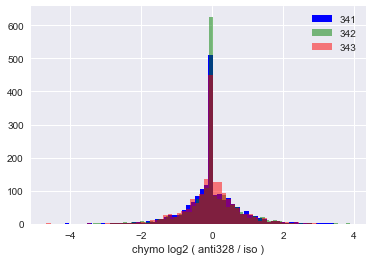

In [47]:
#ratio between anti and control
dfwp2_chymo['341_anti328_div_iso'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfwp2_chymo['342_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfwp2_chymo['343_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
#dfwp2['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
#dfwp2['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
#dfwp2['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('chymo log2 ( anti328 / iso )')
plt.legend()

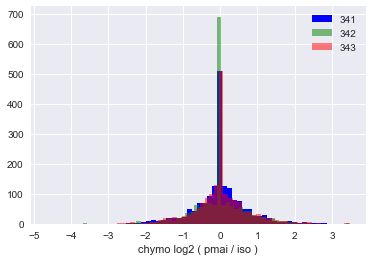

In [48]:
#ratio between pmai and control
dfwp2_chymo['341_pmai_div_iso'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfwp2_chymo['342_pmai_div_iso'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfwp2_chymo['343_pmai_div_iso'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
plt.xlabel('chymo log2 ( pmai / iso )')
plt.legend()

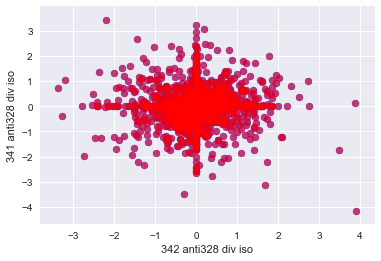

In [49]:
plt.scatter(dfwp2_chymo['342_anti328_div_iso'], dfwp2_chymo['341_anti328_div_iso'], alpha = 0.5, color = 'b')
plt.scatter(dfwp2_chymo['342_anti328_div_iso'], dfwp2_chymo['341_anti328_div_iso'], alpha = 0.5, color = 'r')
#plt.scatter(dfwp2_chymo['341_anti328_div_iso'], dfwp2_chymo['341_anti328_div_iso'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

In [50]:
dfwp2.T.iloc[28:31]

,1,2,4,5,8,9,10,11,12,14,...,3917,3918,3919,3920,3921,3924,3926,3927,3928,3929
15m_anti328_div_iso,0.710976,0,0,0,0,0,0,0,0,0,...,0,0.572887,0,0,0,1.02159,0,0,0,0
6h_anti328_div_iso,0.0702723,0,0,0,0,0,0,0,0,0,...,0,-0.802777,0,0,0,-0.743891,0,0,0,0
18h_anti328_div_iso,0,0,0,0,0,0,0,0,0,0,...,0,-0.857475,0,-1.54443,0,0,0,0,0,0


In [51]:
X_chymo = dfwp2_chymo.set_index("accession").T.fillna(0)
X_subset_chymo = dfwp2_chymo.set_index("accession").T.fillna(0).iloc[16:22,:]
X_subset_chymo_timecourse = dfwp2_chymo.set_index("accession").T.fillna(0).iloc[22:,:]
km_predict = km.fit_predict(X_chymo)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset_chymo)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [52]:
X_subset_chymo = X_subset_chymo_timecourse

In [53]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X_chymo)

hcs = AgglomerativeClustering(n_clusters=3)
hcs_predict = hcs.fit_predict(X_subset_chymo)

In [54]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset_chymo.T)

In [55]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[1 2 0]
[16  2  4 ..., 18  4  4]


In [56]:
X_subset_chymo['replicate_cluster'] = hcs_predict

In [57]:
#sort by replicate clusters
X_subset_ordered_chymo = X_subset_chymo.copy()
X_subset_ordered_chymo['replicate_cluster'] = hcs_predict
X_subset_ordered_chymo = X_subset_ordered_chymo.iloc[:,:-1]

In [58]:
#transpose to sort by accession clusters
X_subset_ordered_chymo = X_subset_ordered_chymo.T
X_subset_ordered_chymo['accession_cluster'] = hcs_rows_predict

In [59]:
cluster_mean = X_subset_ordered_chymo.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [60]:
X_subset_ordered_chymo = X_subset_ordered_chymo.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

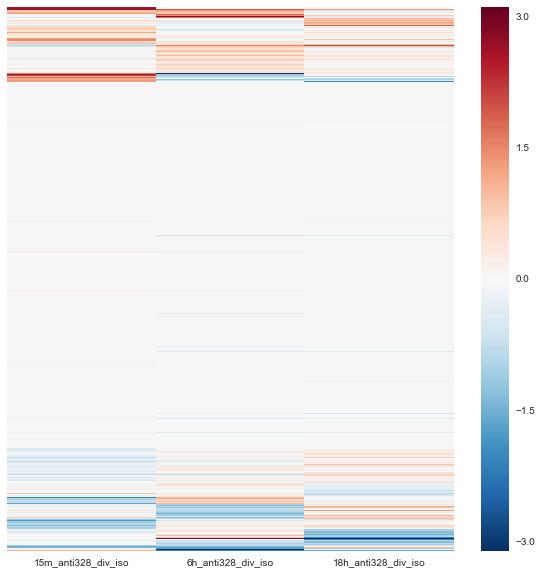

In [61]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered_chymo, xticklabels=True, yticklabels=False)

In [63]:
### GLYCOPROTEIN ANALYSIS --- TRYPSIN ####

In [78]:
#The excel file contains multiple rows of the same accession. These rows should be summed together
dfgp.columns = dfgp.columns.str.lower()
dfgp.columns = [strip_non_ascii(i) for i in dfgp.columns]

dfgp_agg = dfgp.groupby('accession').sum()
#the groupby action sets the grouped column to the index. Reset_index to bring accession back to the column
dfgp0 = dfgp_agg.reset_index()

In [84]:
#df['ids'].str.contains("ball")
peptide_columns = dfgp0.columns[dfgp0.columns.str.contains("peptides")]

In [85]:
#Peptides A corresponds to the unlabeled
#create a mask. True based on these 2 conditions
#A > 0
# abs(A - other column) >= 5
peptide_table = dfgp0[peptide_columns].fillna(0)
compare = peptide_table.iloc[:,0]
compare_to = peptide_table.iloc[:,1:]

In [86]:
# abs(A - other column) >= 5
compare_greater_than_zero = compare > 0
compare_diff = compare_to.sub(compare, axis=0) >= 5

In [87]:
#makes a BIG ASSUMPTION that the peptide mask order corresponds to the column labels
#for example, that Peptide A matches unlabeled
#Peptide B matches 341_anti328
unlabeled_mask = compare_diff.mul(compare_greater_than_zero, axis=0)
data_to_mask = dfgp0.iloc[:,7:16] 

In [89]:
#preprocessing to normalize the Precursor areas
columns_to_normalize = ['341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328',\
                        '343_pmai','342_unlabel','155_iso', '155_anti328', '155_pmai', '15m_iso','15m_anti','6h_iso',\
                        '6h_anti','18h_iso','18h_anti']

#MY normalization method, to the most abundant protein, probably not best one.
#selecting the row with the most peptides 
max_peptide_row = dfgp0[dfgp0.loc[:,'peptides']  == dfgp0.loc[:,'peptides'].max()]
# Step to normalize the precursor areas
#.values[0] converts a pandas series into values, then extracts the one value 
#for column in columns_to_normalize:
#    dfgp1[column] = dfgp1[column] / max_peptide_row[column].values[0]

for column in columns_to_normalize:
    dfgp1[column] = np.log(dfgp1[column].replace(0,np.NaN))
    dfgp1[column] = ((dfgp1[column] - dfgp1[column].mean()) / dfgp1[column].std())
    
#Standard Normalization Method, Centers mean around 0 and STD = 1
#for column in columns_to_normalize:
#    dfgp1[column] = ((dfgp1[column] - dfgp1[column].mean()) / dfgp1[column].std())

KeyError: 'the label [peptides] is not in the [columns]'

In [ ]:
plt.figure(figsize=(14,7))
for col in dfgp1.columns[6:19]:
    dfgp1[col].hist(label=col, alpha=.5)
plt.legend()


In [ ]:
X = dfgp1.set_index("accession").T.fillna(0)
X_subset = dfgp1.set_index("accession").T.fillna(0).iloc[6:15,:]
X_subset_timecourse = dfgp1.set_index("accession").T.fillna(0).iloc[18:24,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [304]:
X_subset = X_subset_timecourse

In [305]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

In [306]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [308]:
new_columns = [ '341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328','343_pmai']
#X_subset = X_subset.T[new_columns]

In [309]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[3 0 0 2 0 1]
[15 15  0 ..., 15 15 15]


In [310]:
X_subset['replicate_cluster'] = hcs_predict

In [311]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [312]:
#transpose to sort by accession clusters
#X_subset_ordered = X_subset_ordered.T[new_columns]
X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [313]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [314]:
X_subset_ordered = X_subset_ordered.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

In [315]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>3]

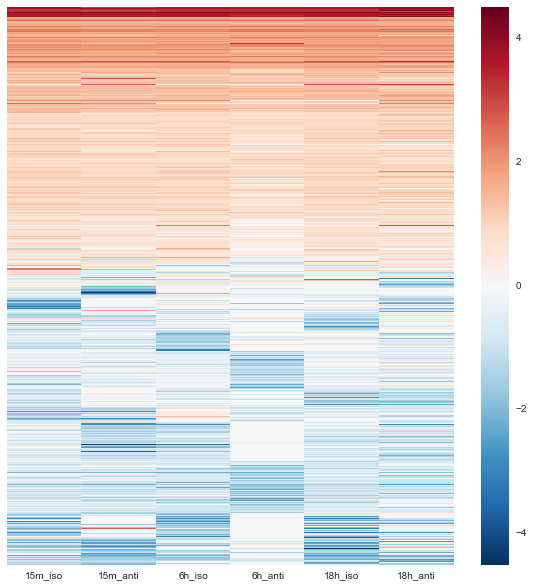

In [316]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=False)

In [599]:
dfgp2 = dfgp1[['accession', '341_iso', '341_anti328', '341_pmai', '342_iso', '342_anti328', '342_pmai', \
             '343_iso', '343_anti328', '343_pmai', '342_unlabel','155_iso','155_anti328','155_pmai','15m_iso',\
             '15m_anti','6h_iso','6h_anti','18h_iso','18h_anti']]

In [600]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfgp2 = dfgp1.fillna(1)
dfgp2['341_anti328_div_iso'] =  dfgp2['341_anti328'] - dfgp2['341_iso']
dfgp2['341_pmai_div_iso'] = dfgp2['341_pmai'] - dfgp2['341_iso']
dfgp2['342_anti328_div_iso'] =  dfgp2['342_anti328'] - dfgp2['342_iso']
dfgp2['342_pmai_div_iso'] = dfgp2['342_pmai'] - dfgp2['342_iso']
dfgp2['343_anti328_div_iso'] =  dfgp2['343_anti328'] - dfgp2['343_iso']
dfgp2['343_pmai_div_iso'] = dfgp2['343_pmai'] - dfgp2['343_iso']
dfgp2['155_anti328_div_iso'] =  dfgp2['155_anti328'] - dfgp2['155_iso']
dfgp2['155_pmai_div_iso'] = dfgp2['155_pmai'] - dfgp2['155_iso']
dfgp2['15m_anti328_div_iso'] =  dfgp2['15m_anti'] - dfgp2['15m_iso']
dfgp2['6h_anti328_div_iso'] =  dfgp2['6h_anti'] - dfgp2['6h_iso']
dfgp2['18h_anti328_div_iso'] =  dfgp2['18h_anti'] - dfgp2['18h_iso']

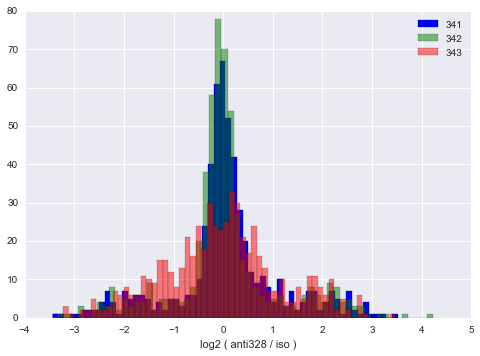

In [601]:
#ratio between anti and control
dfgp2['341_anti328_div_iso'][dfgp2['341_anti328_div_iso'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfgp2['342_anti328_div_iso'][dfgp2['342_anti328_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfgp2['343_anti328_div_iso'][dfgp2['343_anti328_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
#dfgp2['155_anti328_div_iso'][dfgp2['155_anti328_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'orange', label = '155')
#dfgp2['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
#dfgp2['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
#dfgp2['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

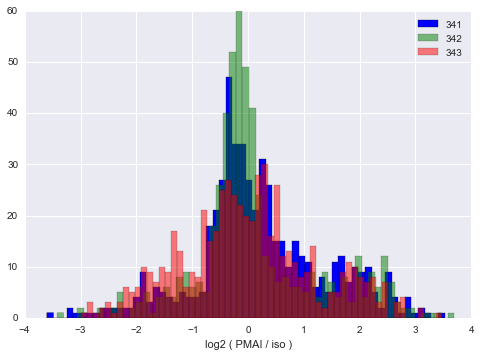

In [602]:
#ratio between pmai and control
#dfgp3 = dfgp2.replace(0,NaN)
dfgp2['341_pmai_div_iso'][dfgp2['341_pmai_div_iso'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfgp2['342_pmai_div_iso'][dfgp2['342_pmai_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfgp2['343_pmai_div_iso'][dfgp2['343_pmai_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
plt.xlabel('log2 ( pmai / iso )')
plt.legend()

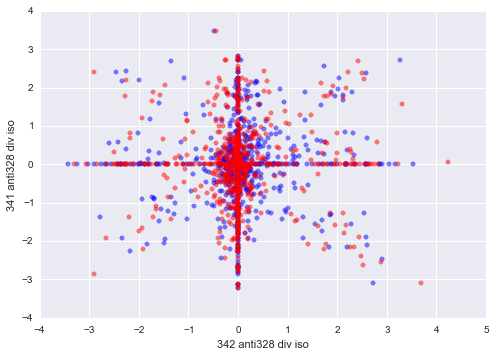

In [603]:
plt.scatter(dfgp2['341_anti328_div_iso'], dfgp2['343_anti328_div_iso'], alpha = 0.5, color = 'b')
plt.scatter(dfgp2['342_anti328_div_iso'], dfgp2['343_anti328_div_iso'], alpha = 0.5, color = 'r')
#plt.scatter(dfgp2['343_anti328_div_iso'], dfgp2['155_anti328_div_iso'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

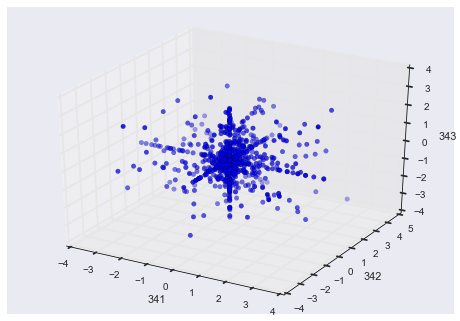

In [604]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(dfgp2['341_anti328_div_iso'], dfgp2['342_anti328_div_iso'], dfgp2['343_anti328_div_iso'])
threedee.set_xlabel('341')
threedee.set_ylabel('342')
threedee.set_zlabel('343')
plt.show()

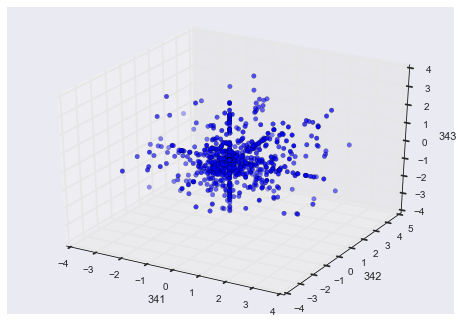

In [605]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(dfgp2['341_pmai_div_iso'], dfgp2['342_pmai_div_iso'], dfgp2['343_pmai_div_iso'])
threedee.set_xlabel('341')
threedee.set_ylabel('342')
threedee.set_zlabel('343')
plt.show()

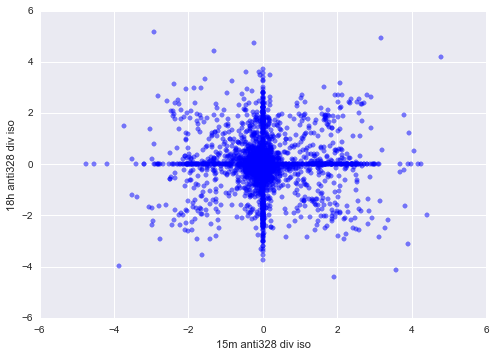

In [606]:
plt.scatter(dfgp2['15m_anti328_div_iso'], dfgp2['18h_anti328_div_iso'], alpha = 0.5, color = 'b')
#plt.scatter(dfgp2['342_anti328_div_iso'], dfgp2['155_anti328_div_iso'], alpha = 0.5, color = 'r')
#plt.scatter(dfgp2['341_anti328_div_iso'], dfgp2['155_anti328_div_iso'], alpha = 0.5, color = 'g')
plt.xlabel('15m anti328 div iso')
plt.ylabel('18h anti328 div iso')

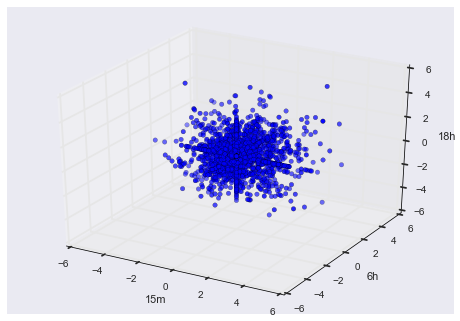

In [607]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfgp2['15m_anti328_div_iso'], dfgp2['6h_anti328_div_iso'], dfgp2['18h_anti328_div_iso'])
threedee1.set_xlabel('15m')
threedee1.set_ylabel('6h')
threedee1.set_zlabel('18h')
plt.show()

In [626]:
X = dfgp2.set_index("accession").T.fillna(0)
X_subset = dfgp2.set_index("accession").T.fillna(0).iloc[67:73,:]
X_subset_timecourse = dfgp2.set_index("accession").T.fillna(0).iloc[75:80,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [640]:
X_subset = X_subset_timecourse

In [643]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=3)
hcs_predict = hcs.fit_predict(X_subset)

In [644]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [645]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[1 2 0]
[ 2  2 19 ...,  2  2  2]


In [646]:
X_subset['replicate_cluster'] = hcs_predict

In [647]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [648]:
#transpose to sort by accession clusters
#X_subset_ordered = X_subset_ordered.T[new_columns]
X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [649]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [650]:
X_subset_ordered = X_subset_ordered.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

In [651]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>0]

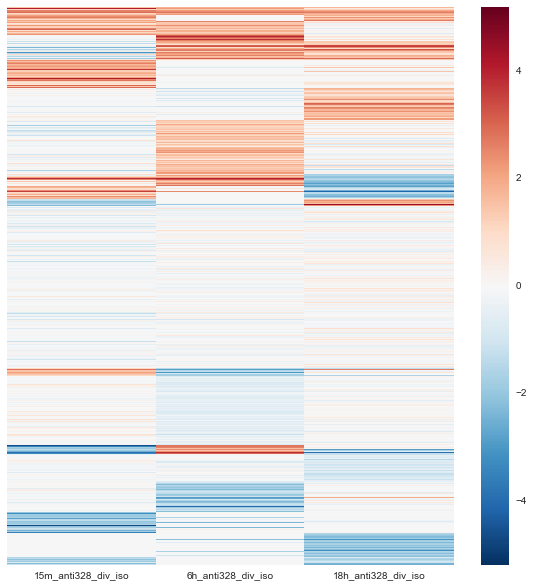

In [652]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=False)

In [111]:
#Writing to excel sheet

dfgp2.to_excel('dfgp2_trypsin.xlsx')

In [ ]:
### GLYCOPROTEIN ANALYSIS --- CHYMOTRYPSIN ###

In [653]:
#The excel file contains multiple rows of the same accession. These rows should be summed together
dfgp_agg_chymo = dfgp_chymo.groupby('accession').sum()
#the groupby action sets the grouped column to the index. Reset_index to bring accession back to the column
dfgp0_chymo = dfgp_agg_chymo.reset_index()

In [654]:
#df['ids'].str.contains("ball")
peptide_columns = dfgp0_chymo.columns[dfgp0_chymo.columns.str.contains("# Peptides ")]

In [655]:
#Peptides A corresponds to the unlabeled
#create a mask. True based on these 2 conditions
#A > 0
# abs(A - other column) >= 5
peptide_table = dfgp0_chymo[peptide_columns].fillna(0)
compare = peptide_table.iloc[:,0]
compare_to = peptide_table.iloc[:,1:]

In [656]:
# abs(A - other column) >= 5
compare_greater_than_zero = compare > 0
compare_diff = compare_to.sub(compare, axis=0) >= 5

In [657]:
#makes a BIG ASSUMPTION that the peptide mask order corresponds to the column labels
#for example, that Peptide A matches unlabeled
#Peptide B matches 341_anti328
unlabeled_mask = compare_diff.mul(compare_greater_than_zero, axis=0)
data_to_mask = dfgp0_chymo.iloc[:,7:16] 

In [658]:
print unlabeled_mask.shape
print data_to_mask.shape

(2734, 9)
(2734, 9)


In [660]:
dfgp1_chymo = dfgp0_chymo

In [661]:
dfgp1_chymo.iloc[:,7:16] = pd.DataFrame(data_to_mask.values*unlabeled_mask.values, columns=data_to_mask.columns, index=data_to_mask.index)

In [662]:
#preprocessing to normalize the Precursor areas
columns_to_normalize = ['341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328',\
                        '343_pmai','342_unlabeled', '15_iso','15_anti','6h_iso',\
                        '6h_anti','18h_iso','18h_anti']

#MY normalization method, to the most abundant protein, probably not best one.
#selecting the row with the most peptides 
#max_peptide_row = dfgp1_chymo[dfgp1_chymo.loc[:,u'\u03a3# Peptides']  == dfgp1_chymo.loc[:,u'\u03a3# Peptides'].max()]
# Step to normalize the precursor areas
#.values[0] converts a pandas series into values, then extracts the one value 
#for column in columns_to_normalize:
#    dfgp1_chymo[column] = dfgp1_chymo[column] / max_peptide_row[column].values[0]

for column in columns_to_normalize:
    dfgp1_chymo[column] = np.log(dfgp1_chymo[column].replace(0,np.NaN))
    dfgp1_chymo[column] = ((dfgp1_chymo[column] - dfgp1_chymo[column].mean()) / dfgp1_chymo[column].std())
    
#Standard Normalization Method, Centers mean around 0 and STD = 1
#for column in columns_to_normalize:
#    dfgp1_chymo[column] = ((dfgp1_chymo[column] - dfgp1_chymo[column].mean()) / dfgp1_chymo[column].std())

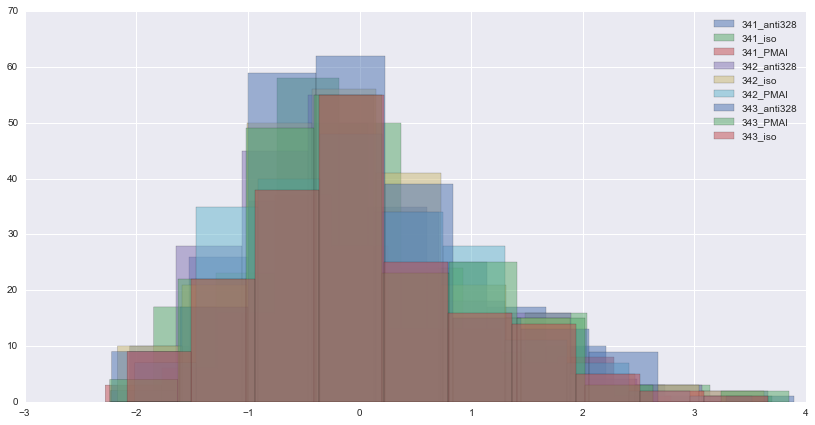

In [663]:
plt.figure(figsize=(14,7))
for col in dfgp1_chymo.columns[7:16]:
    dfgp1_chymo[col].hist(label=col, alpha=.5)
plt.legend()

In [355]:
X_chymo = dfgp1_chymo.set_index("accession").T.fillna(0)
X_subset_chymo = dfgp1_chymo.set_index("accession").T.fillna(0).iloc[6:15,:]
X_subset_timecourse_chymo = dfgp1_chymo.set_index("accession").T.fillna(0).iloc[15:21,:]
km_predict = km.fit_predict(X_chymo)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset_chymo)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [356]:
X_subset_chymo = X_subset_timecourse_chymo

In [358]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X_chymo)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset_chymo)

In [359]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset_chymo.T)

In [361]:
#X_subset_chymo.T.columns
new_columns_chymo = [ '341_iso','341_anti328','341_pmai','342_iso','342_anti328','342_pmai','343_iso','343_anti328','343_pmai','342_unlabel']

In [362]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[0 0 0 3 1 2]
[16  6  6 ..., 13  6 13]


In [364]:
X_subset_chymo['replicate_cluster'] = hcs_predict

In [365]:
#sort by replicate clusters
X_subset_ordered_chymo = X_subset_chymo.copy()
X_subset_ordered_chymo['replicate_cluster'] = hcs_predict
X_subset_ordered_chymo = X_subset_ordered_chymo.iloc[:,:-1]

In [366]:
#transpose to sort by accession clusters
#X_subset_ordered_chymo = X_subset_ordered_chymo.T[new_columns]
X_subset_ordered_chymo = X_subset_ordered_chymo.T
X_subset_ordered_chymo['accession_cluster'] = hcs_rows_predict
#X_subset_ordered['accession_cluster_mean'] = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)

#assigned each accession to a cluster. then sort clusters by sum of replicate means

#X_subset_ordered = X_subset_ordered.sort_values('accession_cluster_mean').iloc[:,:-2]

In [367]:
cluster_mean = X_subset_ordered_chymo.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [368]:
X_subset_ordered_chymo = X_subset_ordered_chymo.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

In [369]:
X_subset_ordered_chymo1 = X_subset_ordered_chymo[np.abs(X_subset_ordered_chymo).sum(axis=1)>0]

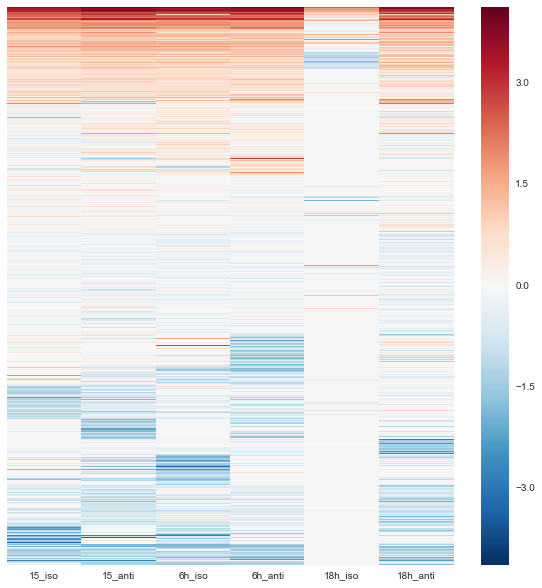

In [370]:
#sort by biological replicate
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered_chymo1, xticklabels=True, yticklabels=False)

In [371]:
new_columns_chymo1 = ['341_iso','342_iso','343_iso','341_anti328','342_anti328','343_anti328','341_pmai','342_pmai','343_pmai']

X_subset_ordered_chymo1 = X_subset_ordered_chymo1[new_columns_chymo1]

KeyError: "['341_iso' '342_iso' '343_iso' '341_anti328' '342_anti328' '343_anti328'\n '341_PMAI' '342_PMAI' '343_PMAI'] not in index"

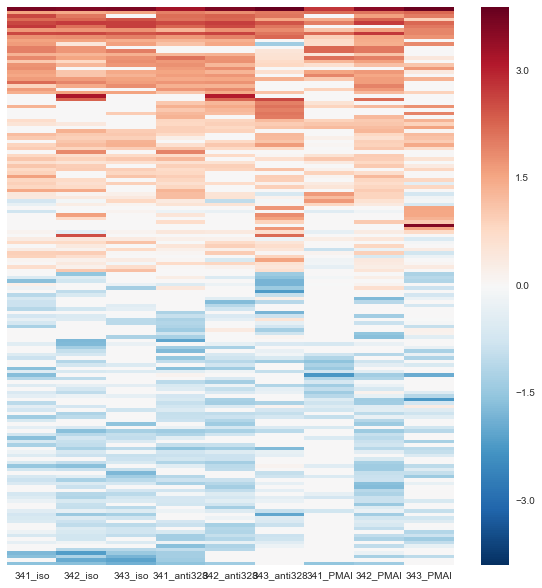

In [180]:
#sort by treatment replicate
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered_chymo1, xticklabels=True, yticklabels=False)

In [664]:
dfgp2_chymo = dfgp1_chymo[['accession', '341_iso', '341_anti328', '341_pmai', '342_iso', '342_anti328', '342_pmai', \
             '343_iso', '343_anti328', '343_pmai', '342_unlabeled','15_iso',\
             '15_anti','6h_iso','6h_anti','18h_iso','18h_anti']]

In [665]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfgp2_chymo = dfgp2_chymo.fillna(0)
dfgp2_chymo['341_anti328_div_iso'] =  dfgp2_chymo['341_anti328'] - dfgp2_chymo['341_iso']
dfgp2_chymo['341_pmai_div_iso'] = dfgp2_chymo['341_pmai'] - dfgp2_chymo['341_iso']
dfgp2_chymo['342_anti328_div_iso'] =  dfgp2_chymo['342_anti328'] - dfgp2_chymo['342_iso']
dfgp2_chymo['342_pmai_div_iso'] = dfgp2_chymo['342_pmai'] - dfgp2_chymo['342_iso']
dfgp2_chymo['343_anti328_div_iso'] =  dfgp2_chymo['343_anti328'] - dfgp2_chymo['343_iso']
dfgp2_chymo['343_pmai_div_iso'] = dfgp2_chymo['343_pmai'] - dfgp2_chymo['343_iso']
dfgp2_chymo['15m_anti328_div_iso'] =  dfgp2_chymo['15_anti'] - dfgp2_chymo['15_iso']
dfgp2_chymo['6h_anti328_div_iso'] =  dfgp2_chymo['6h_anti'] - dfgp2_chymo['6h_iso']
dfgp2_chymo['18h_anti328_div_iso'] =  dfgp2_chymo['18h_anti'] - dfgp2_chymo['18h_iso']

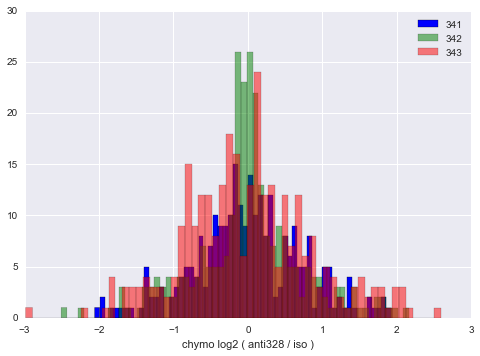

In [666]:
#ratio between anti and control
dfgp2_chymo['341_anti328_div_iso'][dfgp2_chymo['341_anti328_div_iso'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfgp2_chymo['342_anti328_div_iso'][dfgp2_chymo['342_anti328_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfgp2_chymo['343_anti328_div_iso'][dfgp2_chymo['343_anti328_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
plt.xlabel('chymo log2 ( anti328 / iso )')
plt.legend()

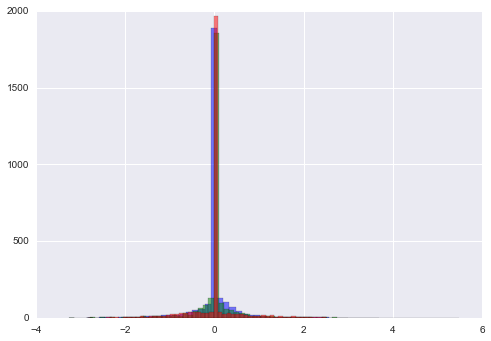

In [667]:
dfgp2_chymo['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'b', label = '15m')
dfgp2_chymo['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'g', label = '6h')
dfgp2_chymo['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'r', label = '18h')

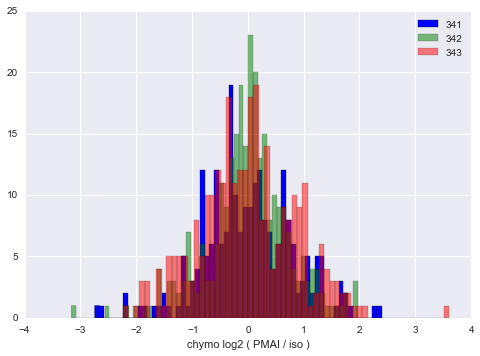

In [668]:
#ratio between pmai and control
dfgp2_chymo['341_pmai_div_iso'][dfgp2_chymo['341_pmai_div_iso'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfgp2_chymo['342_pmai_div_iso'][dfgp2_chymo['342_pmai_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfgp2_chymo['343_pmai_div_iso'][dfgp2_chymo['343_pmai_div_iso'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
plt.xlabel('chymo log2 ( pmai / iso )')
plt.legend()

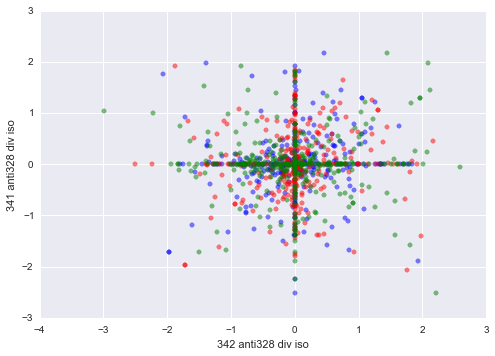

In [669]:
plt.scatter(dfgp2_chymo['341_anti328_div_iso'], dfgp2_chymo['342_anti328_div_iso'], alpha = 0.5, color = 'b')
plt.scatter(dfgp2_chymo['342_anti328_div_iso'], dfgp2_chymo['341_anti328_div_iso'], alpha = 0.5, color = 'r')
plt.scatter(dfgp2_chymo['343_anti328_div_iso'], dfgp2_chymo['342_anti328_div_iso'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

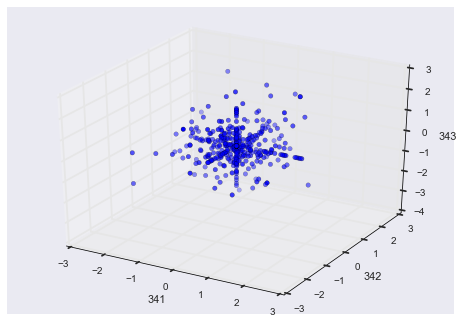

In [670]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfgp2_chymo['341_anti328_div_iso'], dfgp2_chymo['342_anti328_div_iso'], dfgp2_chymo['343_anti328_div_iso'])
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

In [706]:
X_chymo = dfgp2_chymo.set_index("accession").T.fillna(0)
X_subset_chymo = dfgp2_chymo.set_index("accession").T.fillna(0).iloc[16:22,:]
X_subset_timecourse_chymo = dfgp2_chymo.set_index("accession").T.fillna(0).iloc[22:,:]
km_predict = km.fit_predict(X_chymo)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset_chymo)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [694]:
X_subset_chymo = X_subset_timecourse_chymo

In [707]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X_chymo)

hcs = AgglomerativeClustering(n_clusters=3)
hcs_predict = hcs.fit_predict(X_subset_chymo)

In [708]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset_chymo.T)

In [709]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[1 1 2 2 0 0]
[4 4 4 ..., 4 9 4]


In [710]:
X_subset_chymo['replicate_cluster'] = hcs_predict

In [711]:
#sort by replicate clusters
X_subset_ordered_chymo = X_subset_chymo.copy()
X_subset_ordered_chymo['replicate_cluster'] = hcs_predict
X_subset_ordered_chymo = X_subset_ordered_chymo.iloc[:,:-1]

In [712]:
#transpose to sort by accession clusters
#X_subset_ordered_chymo = X_subset_ordered_chymo.T[new_columns]
X_subset_ordered_chymo = X_subset_ordered_chymo.T
X_subset_ordered_chymo['accession_cluster'] = hcs_rows_predict

In [713]:
cluster_mean = X_subset_ordered_chymo.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [714]:
X_subset_ordered_chymo = X_subset_ordered_chymo.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

In [715]:
X_subset_ordered_chymo1 = X_subset_ordered_chymo[np.abs(X_subset_ordered_chymo).sum(axis=1)>0]

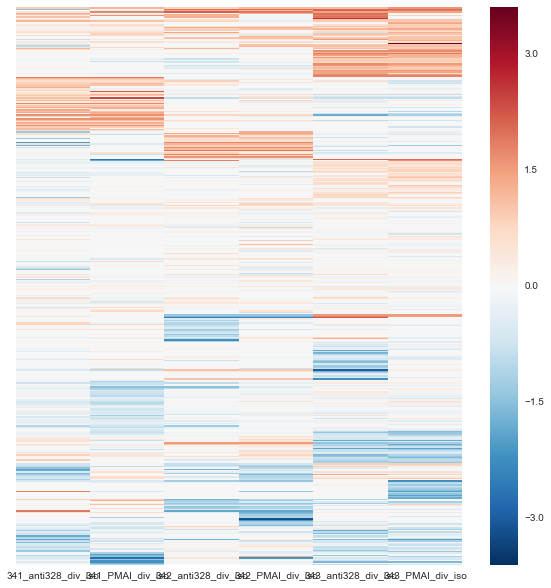

In [716]:
#sort by biological replicate
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered_chymo1, xticklabels=True, yticklabels=False)

In [221]:
#writing to excel
#dfgp2_chymo.to_excel('dfgp2_chymo.xlsx')

In [717]:
### GLYCOPEPTIDE ANALYSIS --- TRYPSIN ###

In [1]:
dfg1 = dfg[['sequence', 'protein group accessions','modifications','pmai_341_1','anti328_342_1',
           'pmai_342_1','iso_342_1','pmai_342_0','iso_342_0','anti328_342_0',
           'pmai_341_0','anti3283_341_1','unlabel_342_1','anti3282_341_1','anti328_341_1',
           'anti328_343_0','anti328_341_0','anti328_343_1','pmaicleave_343_1', 'pmai_343_0',
            'pmaicleave_343_0', 'pmai_343_1','iso_341_1', 'iso_341_0','anti328cleave_343_0',
           'iso_343_0','unlabeled_342_0','iso_155_0','iso_155_1','iso_155_2','iso_155_3','pmai_155_0','pmai_155_1',
            'pmai_155_2','pmai_155_3','anti328_155_0','anti328_155_1','anti328_155_2','anti328_155_3',
            'iso_343_1','iso_15m_0','iso_15m_1','iso_6h_0','iso_6h_1',
           'iso_18h_0','iso_18h_1','anti328_15m_0','anti328_15m_1','anti328_6h_0','anti328_6h_1',
           'anti328_18h_0','anti328_18h_1']]

NameError: name 'dfg' is not defined

In [31]:
#create a dataframe, where sequence is not case sensitive
dfg1['Sequence'] = dfg1['Sequence'].str.upper()

/Users/chris/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [32]:
dfg1 = dfg1.groupby(['Sequence','Protein Group accessions']).mean()

In [33]:
#preprocessing to normalize the Precursor areas
columns_to_normalize = ['pmai_341_1','anti328_342_1',
           'pmai_342_1','iso_342_1','pmai_342_0','iso_342_0','anti328_342_0',
           'pmai_341_0','anti3283_341_1','unlabel_342_1','anti3282_341_1','anti328_341_1',
           'anti328_343_0','anti328_341_0','anti328_343_1','pmaicleave_343_1', 'pmai_343_0',
            'pmaicleave_343_0', 'pmai_343_1','iso_341_1', 'iso_341_0','anti328cleave_343_0',
           'iso_343_0','unlabeled_342_0','iso_155_0','iso_155_1','iso_155_2','iso_155_3','pmai_155_0','pmai_155_1',
            'pmai_155_2','pmai_155_3','anti328_155_0','anti328_155_1','anti328_155_2','anti328_155_3',
            'iso_343_1','iso_15m_0','iso_15m_1','iso_6h_0','iso_6h_1',
           'iso_18h_0','iso_18h_1','anti328_343_1','anti328_15m_0','anti328_15m_1','anti328_6h_0','anti328_6h_1',
           'anti328_18h_0','anti328_18h_1']

#MY normalization method, to the most abundant protein, probably not best one.
#selecting the row with the most peptides 
#max_peptide_row = dfg1[dfg1.loc[:,u'\u03a3# Peptides']  == dfg1.loc[:,u'\u03a3# Peptides'].max()]
# Step to normalize the precursor areas
#.values[0] converts a pandas series into values, then extracts the one value 
#for column in columns_to_normalize:
#    dfg1[column] = dfg1[column] / dfg1[column].max()
    
for column in columns_to_normalize:
    dfg1[column] = np.log2(dfg1[column].replace(0,np.NaN))
    dfg1[column] = ((dfg1[column] - dfg1[column].mean()) / dfg1[column].std())
    
#Standard Normalization Method, Centers mean around 0 and STD = 1
#for column in columns_to_normalize:
#    dfg1[column] = dfg1[column].apply(lambda x: (x - x.mean())/ x.std())
#    dfg1[column] = ((dfg1[column] - dfg1[column].mean()) / dfg1[column].std())

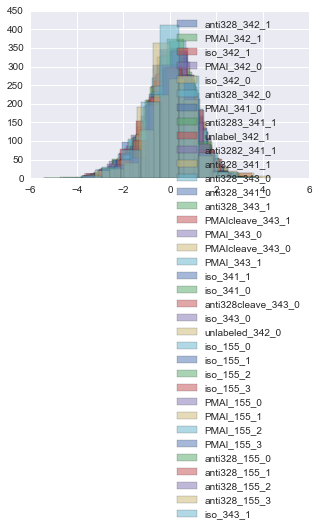

In [34]:
plt.figure(figsize=(5,3))
for col in dfg1.columns[1:37]:
    dfg1[col].hist(label=col, alpha=.5)
plt.legend()

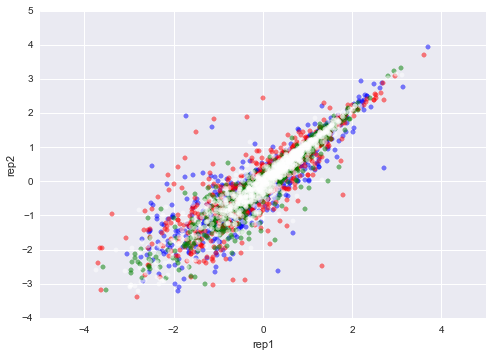

In [47]:
plt.scatter(dfg1['anti328_341_0'], dfg1['anti328_341_1'], alpha = 0.5, color = 'b')
plt.scatter(dfg1['anti328_342_0'], dfg1['anti328_342_1'], alpha = 0.5, color = 'r')
plt.scatter(dfg1['anti328_155_0'], dfg1['anti328_155_1'], alpha = 0.5, color = 'g')
plt.scatter(dfg1['anti328_155_2'], dfg1['anti328_155_3'], alpha = 0.5, color = 'w')
plt.xlabel('rep1')
plt.ylabel('rep2')

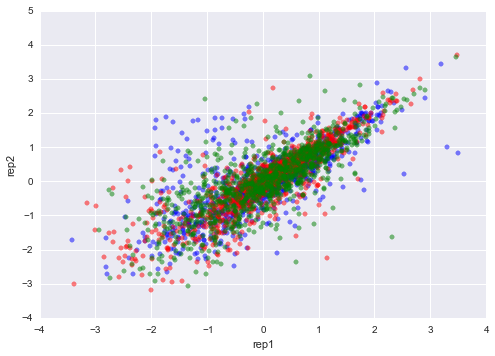

In [51]:
plt.scatter(dfg1['pmai_341_0'], dfg1['pmai_341_1'], alpha = 0.5, color = 'b')
plt.scatter(dfg1['pmai_342_0'], dfg1['pmai_342_1'], alpha = 0.5, color = 'r')
plt.scatter(dfg1['pmai_343_0'], dfg1['pmai_343_1'], alpha = 0.5, color = 'g')
#plt.scatter(dfg1['pmai_155_2'], dfg1['pmai_155_3'], alpha = 0.5, color = 'w')
plt.xlabel('rep1')
plt.ylabel('rep2')

In [61]:
dfg1 = dfg1.reset_index()

In [34]:
X = dfg1.set_index("Sequence").T.fillna(0)
X_subset = dfg1.set_index("Sequence").T.fillna(0).iloc[1:37,:]
X_subset_timecourse = dfg1.set_index("Sequence").T.fillna(0).iloc[37:56,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

ValueError: could not convert string to float: Q9UKA4

In [408]:
X_subset = X_subset_timecourse

In [409]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

In [410]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [411]:
new_columns = ['iso_341_0','anti328_341_0','pmai_341_0','iso_342_0','anti328_342_0','pmai_342_0', 
              'iso_343_0','anti328_343_0','pmai_343_0']
#'iso_155_0','anti328_155_0','pmai_155_0']
#X_subset = X_subset.T[new_columns]

In [412]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[0 0 1 2 0 0 0 0 1 2 3 0]
[15 19  4 ...,  0 13  1]


In [413]:
X_subset['replicate_cluster'] = hcs_predict

In [414]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [415]:
#transpose to sort by accession clusters
#X_subset_ordered = X_subset_ordered.T[new_columns]
X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [416]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [418]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>1]

In [419]:
X_subset_ordered1 = X_subset_ordered1.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

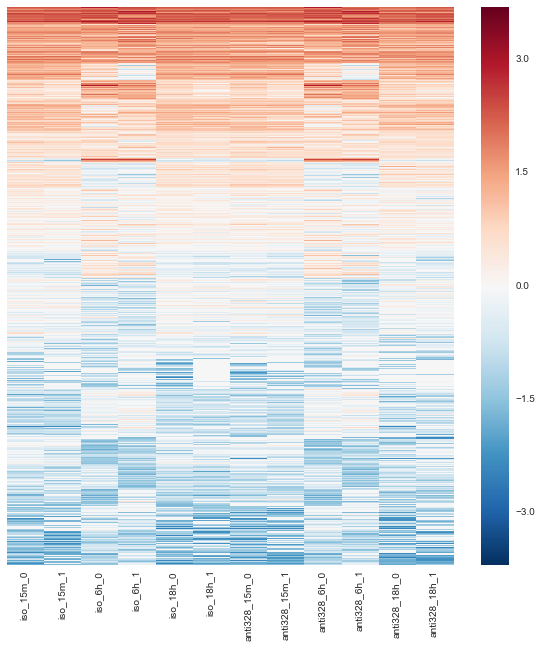

In [421]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=False)

In [194]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfg2 = dfg1.fillna(0)
dfg2['341_anti328_div_iso_0'] =  dfg2['anti328_341_0'] - dfg2['iso_341_0']
dfg2['341_pmai_div_iso_0'] = dfg2['pmai_341_0'] -  dfg2['iso_341_0']
dfg2['341_anti328_div_iso_1'] =  dfg2['anti328_341_1'] - dfg2['iso_341_1']
dfg2['341_pmai_div_iso_1'] = dfg2['pmai_341_1'] - dfg2['iso_341_1']

dfg2['342_anti328_div_iso_0'] =  dfg2['anti328_342_0'] - dfg2['iso_342_0']
dfg2['342_pmai_div_iso_0'] = dfg2['pmai_342_0'] - dfg2['iso_342_0']
dfg2['342_anti328_div_iso_1'] =  dfg2['anti328_342_1'] - dfg2['iso_342_1']
dfg2['342_pmai_div_iso_1'] = dfg2['pmai_342_1'] - dfg2['iso_342_1']

dfg2['343_anti328_div_iso_0'] =  dfg2['anti328_343_0'] - dfg2['iso_343_0']
dfg2['343_pmai_div_iso_0'] = dfg2['pmai_343_0'] - dfg2['iso_343_0']
dfg2['343_anti328_div_iso_1'] =  dfg2['anti328_343_1'] - dfg2['iso_343_1']
dfg2['343_pmai_div_iso_1'] = dfg2['pmai_343_1'] - dfg2['iso_343_1']

dfg2['155_anti328_div_iso_0'] =  dfg2['anti328_155_0'] - dfg2['iso_155_0']
dfg2['155_pmai_div_iso_0'] = dfg2['pmai_155_0'] - dfg2['iso_155_0']
dfg2['155_anti328_div_iso_1'] =  dfg2['anti328_155_1'] - dfg2['iso_155_1']
dfg2['155_pmai_div_iso_1'] = dfg2['pmai_155_1'] - dfg2['iso_155_1']
dfg2['155_anti328_div_iso_2'] =  dfg2['anti328_155_2'] - dfg2['iso_155_2']
dfg2['155_pmai_div_iso_2'] = dfg2['pmai_155_2'] - dfg2['iso_155_2']
dfg2['155_anti328_div_iso_3'] =  dfg2['anti328_155_3'] - dfg2['iso_155_3']
dfg2['155_pmai_div_iso_3'] = dfg2['pmai_155_3'] - dfg2['iso_155_3']

dfg2['15m_anti328_div_iso_0'] =  dfg2['anti328_15m_0'] - dfg2['iso_15m_0']
dfg2['15m_anti328_div_iso_1'] =  dfg2['anti328_15m_1'] - dfg2['iso_15m_1']
dfg2['6h_anti328_div_iso_0'] =  dfg2['anti328_6h_0'] - dfg2['iso_6h_0']
dfg2['6h_anti328_div_iso_1'] =  dfg2['anti328_6h_1'] - dfg2['iso_6h_1']
dfg2['18h_anti328_div_iso_0'] =  dfg2['anti328_18h_0'] - dfg2['iso_18h_0']
dfg2['18h_anti328_div_iso_1'] =  dfg2['anti328_18h_1'] - dfg2['iso_18h_1']

#dfg2 = dfg2.fillna(0)

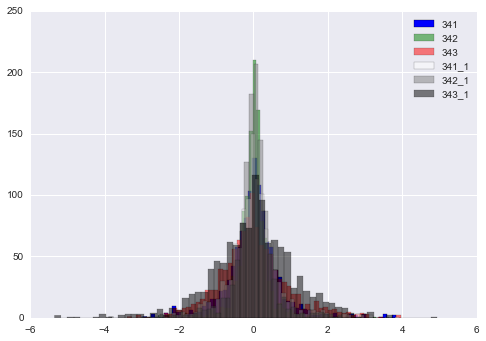

In [63]:
#ratio between anti and control
dfg2['341_anti328_div_iso_0'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfg2['342_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfg2['343_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
dfg2['341_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
dfg2['342_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'grey', label = '342_1')
dfg2['343_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'black', label = '343_1')

plt.legend()

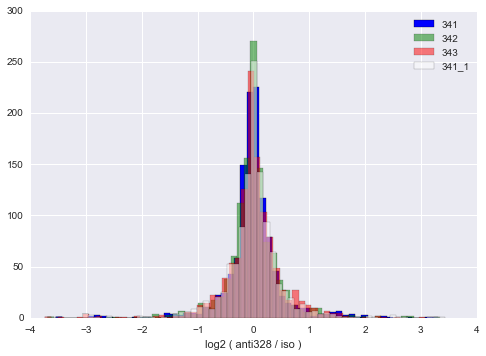

In [64]:
#ratio between anti and control
dfg2['155_anti328_div_iso_0'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfg2['155_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfg2['155_anti328_div_iso_2'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
dfg2['155_anti328_div_iso_3'].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

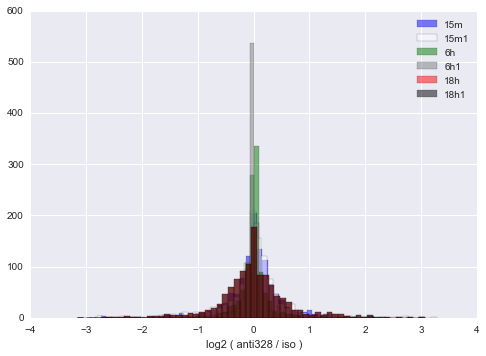

In [65]:
#ratio between anti and control time course
dfg2['15m_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'b', label = '15m')
dfg2['15m_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m1')
dfg2['6h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'g', label = '6h')
dfg2['6h_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h1')
dfg2['18h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'r', label = '18h')
dfg2['18h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h1')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

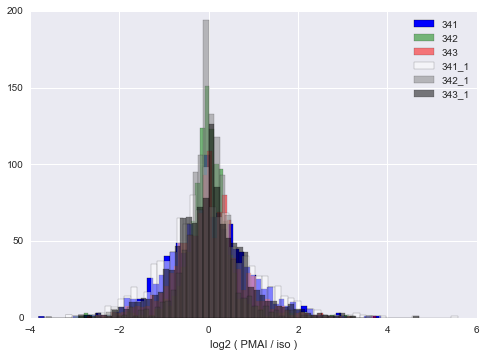

In [66]:
#ratio between pmai and control
dfg2['341_pmai_div_iso_0'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfg2['342_pmai_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfg2['343_pmai_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
dfg2['341_pmai_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
dfg2['342_pmai_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'grey', label = '342_1')
dfg2['343_pmai_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'black', label = '343_1')
plt.xlabel('log2 ( pmai / iso )')
plt.legend()

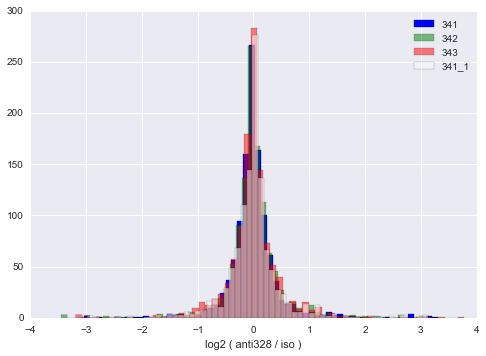

In [67]:
#ratio between anti and control
dfg2['155_pmai_div_iso_0'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfg2['155_pmai_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfg2['155_pmai_div_iso_2'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
dfg2['155_pmai_div_iso_3'].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

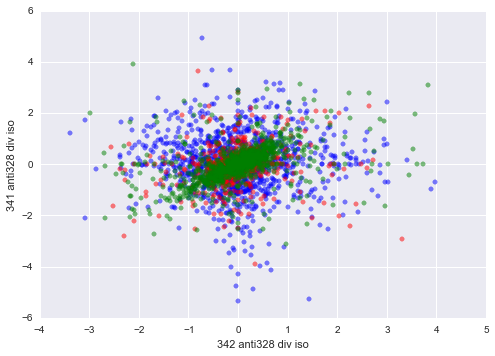

In [68]:
plt.scatter(dfg2['343_anti328_div_iso_0'], dfg2['343_anti328_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(dfg2['342_anti328_div_iso_0'], dfg2['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(dfg2['341_anti328_div_iso_0'], dfg2['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

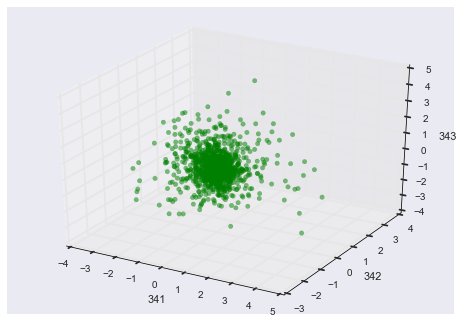

In [69]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg2['341_anti328_div_iso_0'], dfg2['342_anti328_div_iso_0'], dfg2['343_anti328_div_iso_0'], alpha = 0.5, color = 'g')
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

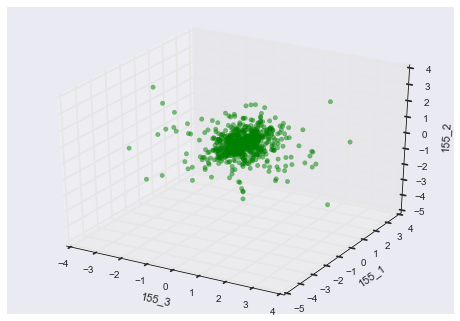

In [70]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg2['155_anti328_div_iso_3'], dfg2['155_anti328_div_iso_1'], dfg2['155_anti328_div_iso_2'], alpha = 0.5, color = 'g')
threedee1.set_xlabel('155_3')
threedee1.set_ylabel('155_1')
threedee1.set_zlabel('155_2')
plt.show()

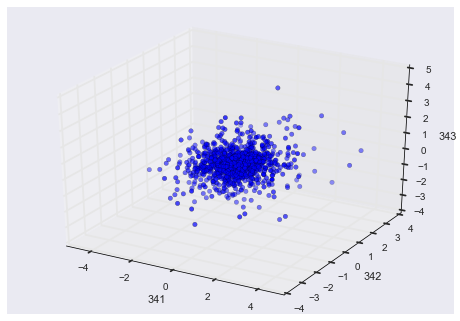

In [71]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg2['341_pmai_div_iso_0'], dfg2['342_pmai_div_iso_0'], dfg2['343_pmai_div_iso_0'])
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

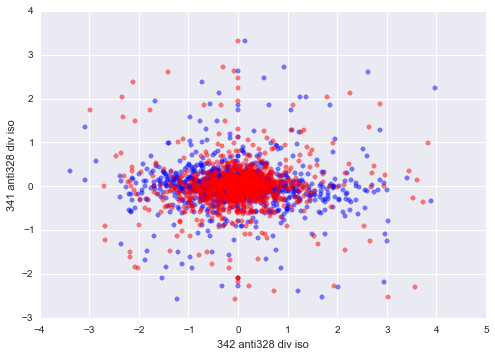

In [72]:
plt.scatter(dfg2['343_anti328_div_iso_0'], dfg2['342_anti328_div_iso_0'], alpha = 0.5, color = 'b')
plt.scatter(dfg2['341_anti328_div_iso_0'], dfg2['342_anti328_div_iso_0'], alpha = 0.5, color = 'r')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

In [410]:
X = dfg2.set_index(['Sequence','Protein Group accessions']).T.fillna(0)
X_subset = dfg2.set_index(['Sequence','Protein Group accessions']).T.fillna(0).iloc[49:61,:]
X_subset_timecourse = dfg2.set_index(['Sequence','Protein Group accessions']).T.fillna(0).iloc[69:79,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [411]:
#X_subset = X_subset_timecourse

In [412]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

In [413]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [414]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[2 2 2 2 3 3 3 3 1 1 0 0]
[17  8  1 ...,  0  5 15]


In [415]:
X_subset['replicate_cluster'] = hcs_predict

In [416]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [417]:
new_columns = ['341_anti328_div_iso_0','341_pmai_div_iso_0','342_anti328_div_iso_0','342_pmai_div_iso_0','343_anti328_div_iso_0','343_pmai_div_iso_0']

In [418]:
#transpose to sort by accession clusters
X_subset_ordered = X_subset_ordered.T[new_columns]
#X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [419]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [420]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>0].iloc[:,:-1]

In [421]:
X_subset_ordered2 = X_subset_ordered1.iloc[X_subset_ordered1.index.
                                           get_level_values('Protein Group accessions') == 'P37198'].iloc[:,:-1]

In [220]:
X_subset_ordered1 = X_subset_ordered1.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

In [422]:
plt.figure(figsize=(5, 3))
seaborn.heatmap(X_subset_ordered2, xticklabels=True, yticklabels=True)

ValueError: zero-size array to reduction operation minimum which has no identity

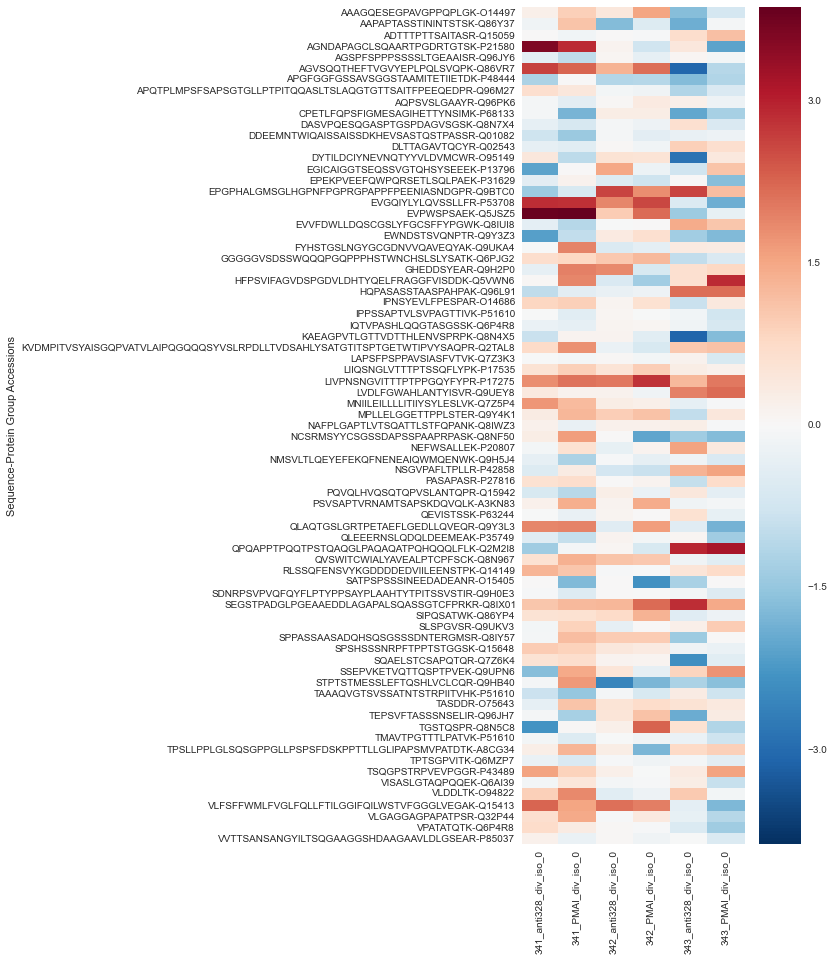

In [342]:
plt.figure(figsize=(5, 15))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=True)

In [1015]:
dfg2.columns[3:40]

Index([          u'iso_342_1',          u'PMAI_342_0',           u'iso_342_0',
             u'anti328_342_0',          u'PMAI_341_0',      u'anti3283_341_1',
             u'unlabel_342_1',      u'anti3282_341_1',       u'anti328_341_1',
             u'anti328_343_0',       u'anti328_341_0',       u'anti328_343_1',
          u'PMAIcleave_343_1',          u'PMAI_343_0',    u'PMAIcleave_343_0',
                u'PMAI_343_1',           u'iso_341_1',           u'iso_341_0',
       u'anti328cleave_343_0',           u'iso_343_0',     u'unlabeled_342_0',
                 u'iso_155_0',           u'iso_155_1',           u'iso_155_2',
                 u'iso_155_3',          u'PMAI_155_0',          u'PMAI_155_1',
                u'PMAI_155_2',          u'PMAI_155_3',       u'anti328_155_0',
             u'anti328_155_1',       u'anti328_155_2',       u'anti328_155_3',
                 u'iso_343_1',           u'iso_15m_0',           u'iso_15m_1',
                  u'iso_6h_0'],
      dtype='object'

In [1020]:
#methods to expose data
#filter (select a subset. e.g. only sequences showing in all replicates)
#group (sum or mean of grouped data. e.g. groups of sequences)
#change chart type to expose data

min_replicates = 10
num_replicates_greater_than_zero = (np.abs(dfg2[dfg2.columns[52:72]]) > 0.5).sum(1)


dfg3 = dfg2[num_replicates_greater_than_zero >= min_replicates]

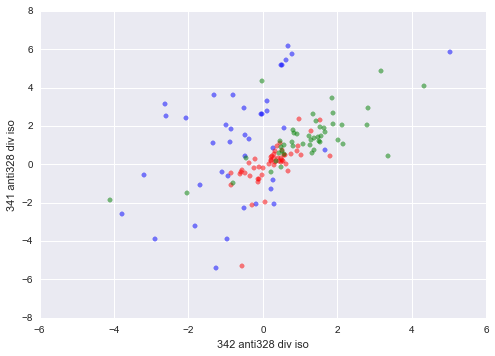

In [1021]:
plt.scatter(dfg3['343_anti328_div_iso_0'], dfg3['343_anti328_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(dfg3['342_anti328_div_iso_0'], dfg3['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(dfg3['341_anti328_div_iso_0'], dfg3['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

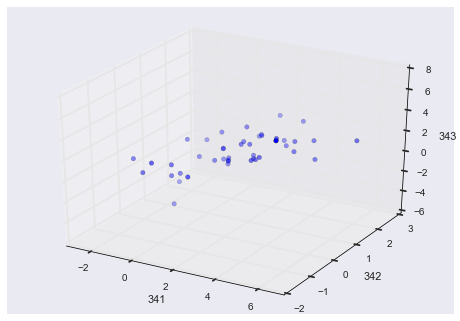

In [1022]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg3['341_pmai_div_iso_0'], dfg3['342_pmai_div_iso_0'], dfg3['343_pmai_div_iso_0'])
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

In [1054]:
dfg2.to_excel('dfg2_trypsin.xlsx')

In [1024]:
### GLYCOPEPTIDE ANALYSIS -- CHYMOTRYPSIN ###

In [34]:
dfg1_chymo = dfg_chymo[['Sequence', 'Protein Group accessions','Modifications','iso_341_0',
                        'iso_341_1','iso_342_0','iso_342_1', 'iso_343_0','iso_343_1', 'anti328_341_0',
                    'anti328_341_1','anti328_342_0','anti328_342_1','anti328_343_0','anti328_343_1','pmai_341_0',
                       'pmai_341_1','pmai_342_0','pmai_342_1','pmai_343_0','pmai_343_1','anti328_15m_0',
                    'anti328_15m_1','iso_15m_0','iso_15m_1','iso_6h_0','iso_6h_1','anti328_6h_0',
                     'anti328_6h_1','iso_18h_0','iso_18h_1','anti328_18h_0','anti328_18h_1', 'unlabeled_342_1','unlabeled_342_0']]

In [35]:
#create a dataframe, where sequence is not case sensitive
dfg1_chymo['Sequence'] = dfg1_chymo['Sequence'].str.upper()

/Users/christinawoo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
dfg1_chymo = dfg1_chymo.groupby(['Sequence','Protein Group accessions']).mean()

In [37]:
#preprocessing to normalize the Precursor areas
columns_to_normalize = ['iso_341_0',
                        'iso_341_1','iso_342_0','iso_342_1', 'iso_343_0','iso_343_1', 'anti328_341_0',
                    'anti328_341_1','anti328_342_0','anti328_342_1','anti328_343_0','anti328_343_1','pmai_341_0',
                       'pmai_341_1','pmai_342_0','pmai_342_1','pmai_343_0','pmai_343_1','anti328_15m_0',
                    'anti328_15m_1','iso_15m_0','iso_15m_1','iso_6h_0','iso_6h_1','anti328_6h_0',
                     'anti328_6h_1','iso_18h_0','iso_18h_1','anti328_18h_0','anti328_18h_1','unlabeled_342_1','unlabeled_342_0']

for column in columns_to_normalize:
    dfg1_chymo[column] = np.log(dfg1_chymo[column].replace(0,np.NaN))
    dfg1_chymo[column] = ((dfg1_chymo[column] - dfg1_chymo[column].mean()) / dfg1_chymo[column].std())

#Standard Normalization Method, Centers mean around 0 and STD = 1
#for column in columns_to_normalize:
#    dfg1_chymo[column] = ((dfg1_chymo[column] - dfg1_chymo[column].mean()) / dfg1_chymo[column].std())

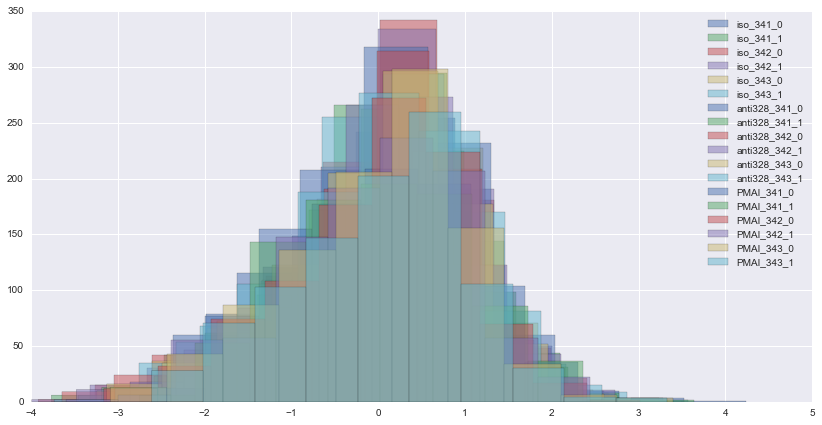

In [38]:
plt.figure(figsize=(14,7))
for col in dfg1_chymo.columns[0:18]:
    dfg1_chymo[col].hist(label=col, alpha=.5)
plt.legend()

In [39]:
dfg1_chymo = dfg1_chymo.reset_index()

In [51]:
X = dfg1_chymo.set_index("Sequence").drop('Protein Group accessions',1).T.fillna(0)

X_subset = X.iloc[:17,:]
X_subset_timecourse = X.iloc[17:,:]

km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [434]:
X_subset = X_subset_timecourse

In [53]:
kms_predict

array([0, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1, 1, 3, 3, 3, 3, 1], dtype=int32)

In [435]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

In [436]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [437]:
new_columns = ['iso_341_0','anti328_341_0','pmai_341_0','iso_342_0','anti328_342_0','pmai_342_0', 
              'iso_343_0','anti328_343_0','pmai_343_0']
#'iso_155_0','anti328_155_0','pmai_155_0']
#X_subset = X_subset.T[new_columns]

In [438]:
#clusters of the columns (replicates)
print hcs_predict
#clusters of the rows (accessions)
print hcs_rows_predict

[1 0 1 0 3 0 3 0 1 0 2 2]
[ 4 19  1 ...,  2  2  2]


In [439]:
X_subset['replicate_cluster'] = hcs_predict

In [440]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [441]:
#transpose to sort by accession clusters
#X_subset_ordered = X_subset_ordered.T[new_columns]
X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [442]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [444]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>0]

In [445]:
X_subset_ordered1 = X_subset_ordered1.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

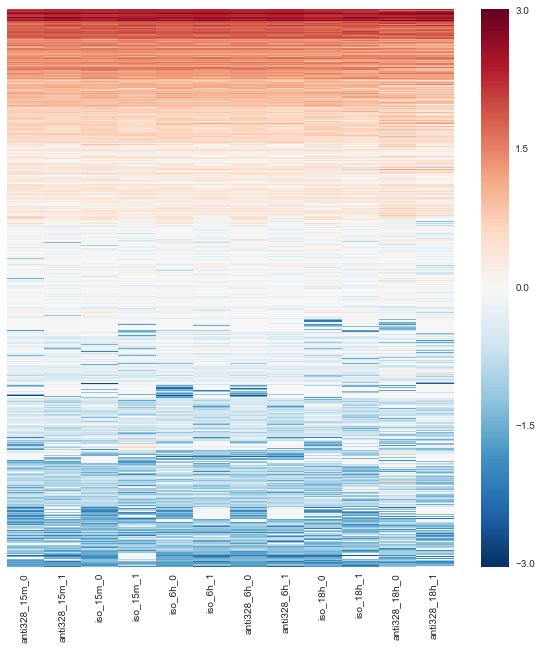

In [446]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=False)

In [57]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero
dfg2_chymo = dfg1_chymo.fillna(0)
dfg2_chymo['341_anti328_div_iso_0'] =  dfg2_chymo['anti328_341_0'] - dfg2_chymo['iso_341_0']
dfg2_chymo['341_pmai_div_iso_0'] = dfg2_chymo['pmai_341_0'] -  dfg2_chymo['iso_341_0']
dfg2_chymo['341_anti328_div_iso_1'] =  dfg2_chymo['anti328_341_1'] - dfg2_chymo['iso_341_1']
dfg2_chymo['341_pmai_div_iso_1'] = dfg2_chymo['pmai_341_1'] - dfg2_chymo['iso_341_1']

dfg2_chymo['342_anti328_div_iso_0'] =  dfg2_chymo['anti328_342_0'] - dfg2_chymo['iso_342_0']
dfg2_chymo['342_pmai_div_iso_0'] = dfg2_chymo['pmai_342_0'] - dfg2_chymo['iso_342_0']
dfg2_chymo['342_anti328_div_iso_1'] =  dfg2_chymo['anti328_342_1'] - dfg2_chymo['iso_342_1']
dfg2_chymo['342_pmai_div_iso_1'] = dfg2_chymo['pmai_342_1'] - dfg2_chymo['iso_342_1']

dfg2_chymo['343_anti328_div_iso_0'] =  dfg2_chymo['unlabeled_342_0'] - dfg2_chymo['iso_343_0']
dfg2_chymo['343_pmai_div_iso_0'] = dfg2_chymo['pmai_343_0'] - dfg2_chymo['iso_343_0']
dfg2_chymo['343_anti328_div_iso_1'] =  dfg2_chymo['unlabeled_342_1'] - dfg2_chymo['iso_343_1']
dfg2_chymo['343_pmai_div_iso_1'] = dfg2_chymo['pmai_343_1'] - dfg2_chymo['iso_343_1']

dfg2_chymo['15m_anti328_div_iso_0'] =  dfg2_chymo['anti328_15m_0'] - dfg2_chymo['iso_15m_0']
dfg2_chymo['15m_anti328_div_iso_1'] =  dfg2_chymo['anti328_15m_1'] - dfg2_chymo['iso_15m_1']
dfg2_chymo['6h_anti328_div_iso_0'] =  dfg2_chymo['anti328_6h_0'] - dfg2_chymo['iso_6h_0']
dfg2_chymo['6h_anti328_div_iso_1'] =  dfg2_chymo['anti328_6h_1'] - dfg2_chymo['iso_6h_1']
dfg2_chymo['18h_anti328_div_iso_0'] =  dfg2_chymo['anti328_18h_0'] - dfg2_chymo['iso_18h_0']
dfg2_chymo['18h_anti328_div_iso_1'] =  dfg2_chymo['anti328_18h_1'] - dfg2_chymo['iso_18h_1']
#dfg2 = dfg2.fillna(0)

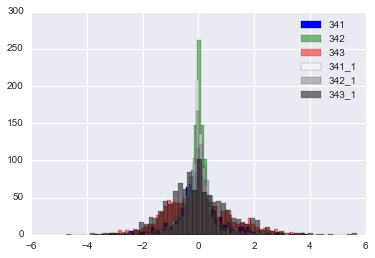

In [58]:
#ratio between anti and control
dfg2_chymo['341_anti328_div_iso_0'].hist(bins=60, alpha = 1, color = 'b', label = '341')
dfg2_chymo['342_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
dfg2_chymo['343_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
dfg2_chymo['341_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
dfg2_chymo['342_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'grey', label = '342_1')
dfg2_chymo['343_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'black', label = '343_1')

plt.legend()

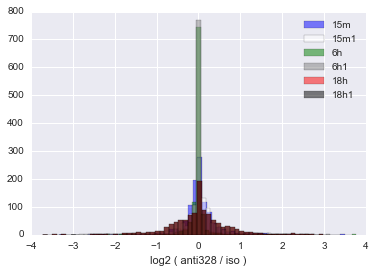

In [59]:
#ratio between anti and control time course
dfg2_chymo['15m_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'b', label = '15m')
dfg2_chymo['15m_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m1')
dfg2_chymo['6h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'g', label = '6h')
dfg2_chymo['6h_anti328_div_iso_1'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h1')
dfg2_chymo['18h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'r', label = '18h')
dfg2_chymo['18h_anti328_div_iso_0'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h1')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

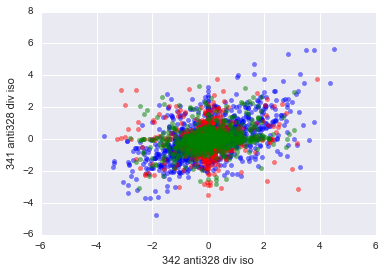

In [60]:
plt.scatter(dfg2_chymo['343_anti328_div_iso_0'], dfg2_chymo['343_anti328_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(dfg2_chymo['342_anti328_div_iso_0'], dfg2_chymo['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(dfg2_chymo['341_anti328_div_iso_0'], dfg2_chymo['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('342 anti328 div iso')
plt.ylabel('341 anti328 div iso')

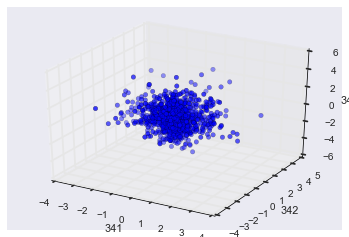

In [61]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg2_chymo['341_anti328_div_iso_0'], dfg2_chymo['342_anti328_div_iso_0'], dfg2_chymo['343_anti328_div_iso_0'])
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

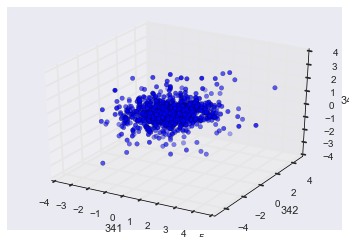

In [62]:
threedee1 = plt.figure().gca(projection='3d')
threedee1.scatter(dfg2_chymo['341_pmai_div_iso_0'], dfg2_chymo['342_pmai_div_iso_0'], dfg2_chymo['343_pmai_div_iso_0'])
threedee1.set_xlabel('341')
threedee1.set_ylabel('342')
threedee1.set_zlabel('343')
plt.show()

In [63]:
X = dfg2_chymo.set_index(['Sequence','Protein Group accessions']).T.fillna(0)
X_subset = dfg2_chymo.set_index(['Sequence','Protein Group accessions']).T.fillna(0).iloc[32:44,:]
X_subset_timecourse = dfg2_chymo.set_index(['Sequence','Protein Group accessions']).T.fillna(0).iloc[44:50,:]
km_predict = km.fit_predict(X)

kms = KMeans(n_clusters=4)
kms_predict = kms.fit_predict(X_subset)
#for idx, column in enumerate(X.index):
#    print "{}, cluster: {}".format(column,km_predict[idx])

In [64]:
#X_subset = X_subset_timecourse

In [65]:
#hierarchical clustering
hc = AgglomerativeClustering(n_clusters=5)
hc_predict = hc.fit_predict(X)

hcs = AgglomerativeClustering(n_clusters=4)
hcs_predict = hcs.fit_predict(X_subset)

In [66]:
hcs_rows = AgglomerativeClustering(n_clusters=20)
hcs_rows_predict = hcs_rows.fit_predict(X_subset.T)

In [68]:
#clusters of the columns (replicates)
print(hcs_predict)
#clusters of the rows (accessions)
print(hcs_rows_predict)

[0 2 0 2 0 3 3 3 1 0 1 0]
[ 4 15  6 ..., 10  4 10]


In [69]:
X_subset['replicate_cluster'] = hcs_predict

In [70]:
#sort by replicate clusters
X_subset_ordered = X_subset.copy()
X_subset_ordered['replicate_cluster'] = hcs_predict
X_subset_ordered = X_subset_ordered.iloc[:,:-1]

In [71]:
new_columns = ['341_anti328_div_iso_0','341_pmai_div_iso_0','342_anti328_div_iso_0','342_pmai_div_iso_0','343_anti328_div_iso_0','343_pmai_div_iso_0']

In [72]:
#transpose to sort by accession clusters
X_subset_ordered = X_subset_ordered.T[new_columns]
#X_subset_ordered = X_subset_ordered.T
X_subset_ordered['accession_cluster'] = hcs_rows_predict

In [73]:
cluster_mean = X_subset_ordered.groupby('accession_cluster').mean().sum(axis=1)
cluster_mean = cluster_mean.reset_index()
cluster_mean.columns = ['accession_cluster','accession_cluster_mean']

In [78]:
X_subset_ordered1 = X_subset_ordered[np.abs(X_subset_ordered).sum(axis=1)>0]

In [98]:
X_subset_ordered2 = X_subset_ordered1.iloc[X_subset_ordered1.index.
                                           get_level_values('Protein Group accessions') == 'O14974'].iloc[:,:-1]

In [76]:
X_subset_ordered1 = X_subset_ordered1.merge(cluster_mean).sort_values('accession_cluster_mean', ascending=False).iloc[:,:-2]

/Users/christinawoo/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


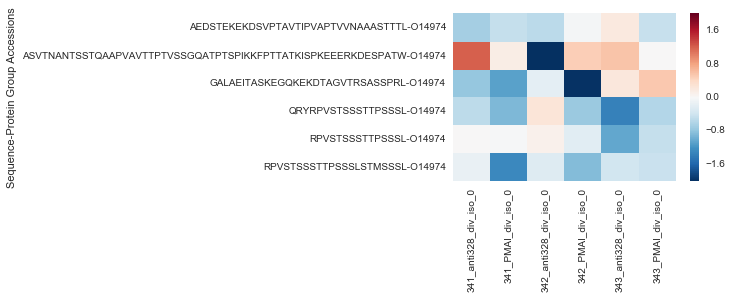

In [101]:
plt.figure(figsize=(5, 3))
seaborn.heatmap(X_subset_ordered2, xticklabels=True, yticklabels=True, vmin=-2., vmax=2., center=0)

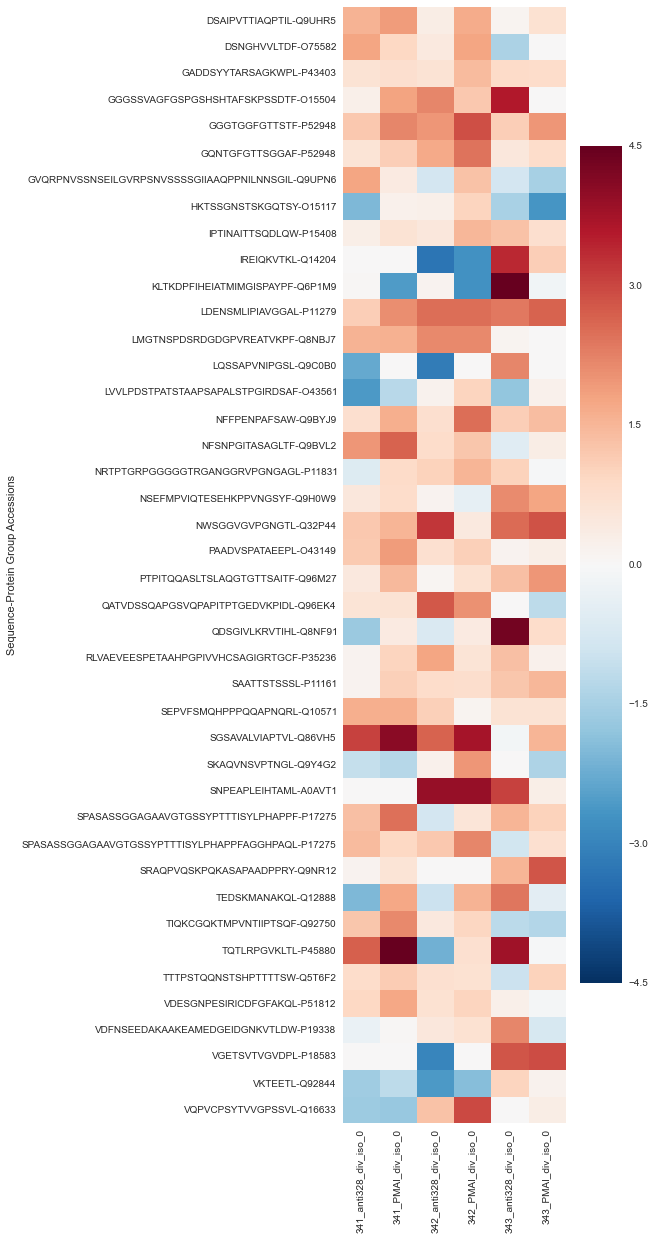

In [273]:
plt.figure(figsize=(5, 20))
seaborn.heatmap(X_subset_ordered1, xticklabels=True, yticklabels=True)

In [191]:
dfg2_chymo.to_excel('dfg2_chymo.xlsx')

In [214]:
###### ANDREW ANALYSIS MERGING GLYCOPEPTIDE AND GLYCOPROTEIN FILES ###

In [215]:
dfg_select = dfg[['Sequence','Protein Group accessions','Modifications','Precursor Area', 'Glycan composition','Spectrum File']]

In [216]:
dfg_group = dfg_select.groupby('Protein Group accessions').sum()
dfg_group = dfg_group.fillna(0)
#dfg_group.columns= dfg_group.columns.droplevel()

In [217]:
#set dfgp_group index name to match dfp4 index name
#dfgp_group.index.names = ['accession']
dfg_group = dfg_group.reset_index();

In [218]:
#rename for consistency to merge
dfg_group.rename(columns={'glycan_Protein Group accessions':'accession'}, inplace=True) 

In [219]:
renamed = ['glycan_' + column  for column in dfg_group.columns]
dfg_group.columns = renamed
dfg_group.rename(columns={'glycan_Protein Group accessions':'accession'}, inplace=True)

In [220]:
protein_peptide_merge = dfg_group.merge(dfgp2, on='accession',how='left')

NameError: name 'dfgp2' is not defined

In [ ]:
protein_peptide_merge = protein_peptide_merge.set_index('accession')

In [ ]:
protein_peptide_merge['sum'] = protein_peptide_merge.sum(1)
protein_peptide_mergesort = protein_peptide_merge.sort_values(columns='sum', ascending= False)

In [ ]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(protein_peptide_mergesort.iloc[:,:-1],vmin=-3, vmax=3,  xticklabels=True, yticklabels=True)

In [1093]:
dfg_group1 = dfg_group.set_index('accession').iloc[:,-12:-1]
dfg_group1['sum'] = dfg_group1.sum(1)
dfg_group2 = dfg_group1.sort_values(columns='sum', ascending= False)

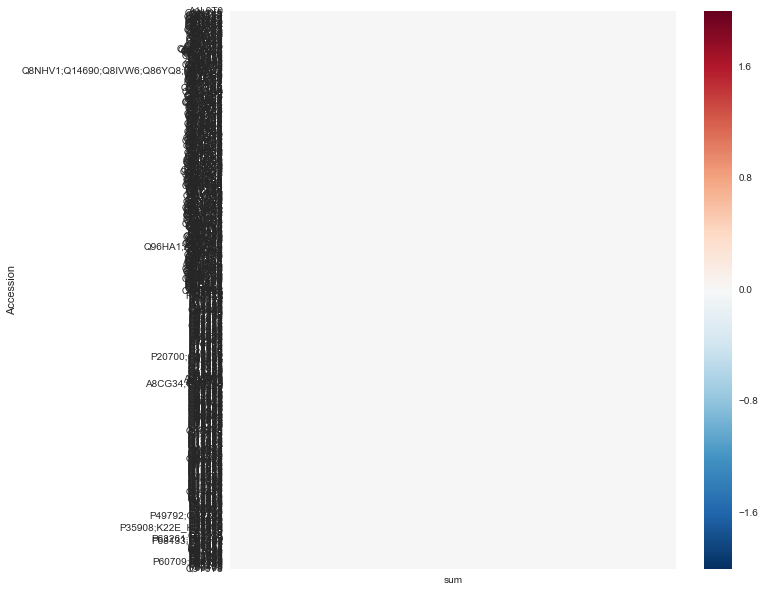

In [1097]:
plt.figure(figsize=(10, 10))
seaborn.heatmap(dfg_group2.iloc[:,:], vmin=-2, vmax=2, xticklabels=True, yticklabels=True)

In [6]:
### CHART PATTERN ANALYSIS TRYPSIN ###

In [163]:
cp = pd.read_excel(chartpattern,sheetname='Sheet1')

In [165]:
cp_amp_mean = cp.groupby('File name').mean()['amplitude']
cp_amp_mean = pd.DataFrame(cp_amp_mean).reset_index()
cp_amp_mean.columns = ['File name', 'amplitude_mean']

In [166]:
cp_amp_std = cp.groupby('File name').std()['amplitude']
cp_amp_std = pd.DataFrame(cp_amp_std).reset_index()
cp_amp_std.columns = ['File name', 'amplitude_std']

In [168]:
cp1 = cp.merge(cp_amp_mean, how='left').merge(cp_amp_std, how='left')
cp1['norm_amplitude'] = (cp1['amplitude'] - cp1['amplitude_mean'] / cp1['amplitude_std'])

In [169]:
cp2 = cp1.copy()
cp2 = cp2.sort_values('score', ascending=False)
cp2['m'] = cp2['m/z'] * cp2['z']

#Christina's set conversion from scanrange to seconds
scanrange_to_time = 0.5
cp2['scan range (seconds)'] = scanrange_to_time * cp2['scan range']
cp2['time start'] = cp2['time'] - cp2['scan range (seconds)']
cp2['time end'] = cp2['time'] + cp2['scan range (seconds)']


In [230]:
mz_limit = 0.01
score_floor = 0
cluster = []
cluster_file = []
agg_amplitude = np.zeros(cp2.shape[0])
agg_index = np.zeros(cp2.shape[0])
agg_index.fill(-1)
exceptions = []

for row in range(cp2.shape[0]):
    if row % 1000 == 0:
        print 'processing row {}'.format(row)
    mz_mask = np.abs(cp2['m/z'] - cp2.loc[row, 'm/z']) <= mz_limit
    z_mask = cp2['z'] == cp2.loc[row, 'z']
    scan_mask = (cp2['time start'] <= cp2.loc[row, 'time end']) | (cp2['time end'] >= cp2.loc[row, 'time start'])
    score_mask = cp2['score'] >= score_floor
    file_mask = cp2['File name'] == cp2.loc[row, 'File name']
    
    cluster_mask = (mz_mask & z_mask & scan_mask & score_mask)
    cluster_file_mask = (mz_mask & z_mask & scan_mask & score_mask & file_mask)
    
    cluster.append(cp2.index[cluster_mask].tolist())
    cluster_file.append(cp2.index[cluster_file_mask].tolist())
    
    #agg_index only calculates based off of cluster, which is conditioned from the 4 masks above
    if len(cluster_file[row]) > 0:
        if cluster_file[row][0] == row:
            agg_index[row] = cluster[-1][0]
            agg_amplitude[row] = cp2.iloc[cluster_file[row],'norm_amplitude'].sum()
    else:
        exceptions.append(row)
        #print cp2.loc[row, 'm/z'], cp2.loc[row, 'z'], cp2.loc[row, 'time end'], cp2.loc[row, 'time start']

processing row 0
processing row 1000
processing row 2000
processing row 3000
processing row 4000
processing row 5000
processing row 6000
processing row 7000
processing row 8000
processing row 9000
processing row 10000
processing row 11000
processing row 12000
processing row 13000
processing row 14000
processing row 15000
processing row 16000
processing row 17000
processing row 18000
processing row 19000
processing row 20000
processing row 21000
processing row 22000
processing row 23000
processing row 24000
processing row 25000
processing row 26000
processing row 27000
processing row 28000
processing row 29000
processing row 30000
processing row 31000
processing row 32000
processing row 33000
processing row 34000
processing row 35000
processing row 36000
processing row 37000
processing row 38000
processing row 39000
processing row 40000
processing row 41000
processing row 42000
processing row 43000
processing row 44000
processing row 45000
processing row 46000
processing row 47000
proce

In [231]:
cp2['agg_amplitude'] = agg_amplitude
cp2['agg_index'] = agg_index
cp2['cluster'] = cluster
cp2['cluster_file'] = cluster_file
#cp2['File name'].astype(int);

In [232]:
#checking that the cluster groups are consistent
#if row 10 cluster contains [10,21,48], that row 21 is also [10,21,48]
#found that it's largely true, 3160 of 3311 clusters are completely identical
#for non-identical, it's still not a major problem because comparisons of pmai, or, control are still valid within the group
cp2['cluster_sum'] = [sum(row) for row in cp2['cluster']]

In [185]:
cp2_pivot = cp2.pivot_table(values='amplitude', index='agg_index', columns=['File name'],aggfunc='sum')

In [1098]:
cp2_pivot

File name,155_PMAI_0,155_PMAI_1,155_PMAI_2,155_PMAI_3,155_control_0,155_control_1,155_control_2,155_control_3,155_or328_0,155_or328_1,...,343_anti328_0,343_anti328_1,343_anti328_cleave_0,343_anti328_cleave_1,343_iso_0,343_iso_1,6h_anti328_0,6h_anti328_1,6h_iso_0,6h_iso_1
agg_index,,,,,,,,,,,,,,,,,,,,,
-1,1768823778,602884437,1631919933,1327479380,2075188419,581085076,1484647771,1482989117,1688051412,716345991,...,1198402697,1053112477,466628788,117968033,1463470284,859655785,62380409,23637036,1387278436,784839670
0,23121143,8718876,14735970,11130702,19023672,6218885,11773914,12976727,14270103,6732969,...,47907249,24458859,NaN,NaN,56772297,33306215,NaN,NaN,42672205,20808348
1,1403650,240310,161151,157544,1910885,359372,358941,352644,1132595,343369,...,4076974,2271117,NaN,NaN,5169873,1856135,NaN,NaN,4005397,1100293
2,3784410,1266407,2248600,2878812,2383060,869407,2957954,2863849,2105024,1174302,...,1014947,1231844,NaN,NaN,4961052,2000394,NaN,NaN,2778022,2789586
4,88766658,28934614,12821358,51628645,108378423,30807728,49123145,76597951,58399197,36893099,...,99462732,86067890,NaN,NaN,81363355,42918099,6384354,559233,149125971,90796725
7,14042548,6688848,17398448,12858100,17193863,6831220,17460222,17731201,13816810,10563313,...,14809615,12045573,NaN,NaN,2533852,822275,NaN,NaN,8156192,5932052
8,7833751,2247676,3187519,3298149,7720302,1803190,3284314,3226725,11670589,4800668,...,15437764,9024660,7611410,2027316,37945101,8025569,NaN,NaN,15955872,8354432
9,4417538,1484315,5800856,5570238,1997976,491893,842217,1362361,2891815,854589,...,524133,1591157,422421,NaN,4359227,2517117,NaN,NaN,6419784,4854129
10,26072288,12208820,35317258,28396184,18865715,7792580,24025791,26683569,7912946,6388837,...,3179638,2809116,1409232,477295,12483446,11147628,NaN,NaN,17501729,10679858


In [ ]:
#preprocessing to normalize the Precursor areas
columns_to_normalize = ['iso_341_0',
                        'iso_341_1','iso_342_0','iso_342_1', 'iso_343_0','iso_343_1', 'anti328_341_0',
                    'anti328_341_1','anti328_342_0','anti328_342_1','anti328_343_0','anti328_343_1','pmai_341_0',
                       'pmai_341_1','pmai_342_0','pmai_342_1','pmai_343_0','pmai_343_1','anti328_15m_0',
                    'anti328_15m_1','iso_15m_0','iso_15m_1','iso_6h_0','iso_6h_1','anti328_6h_0',
                     'anti328_6h_1','iso_18h_0','iso_18h_1','anti328_18h_0','anti328_18h_1','unlabeled_342_1','unlabeled_342_0']

#MY normalization method, to the most abundant protein, probably not best one.
#selecting the row with the most peptides 
#max_peptide_row = dfg1[dfg1.loc[:,u'\u03a3# Peptides']  == dfg1.loc[:,u'\u03a3# Peptides'].max()]
# Step to normalize the precursor areas
#.values[0] converts a pandas series into values, then extracts the one value 
for column in columns_to_normalize:
    dfg1_chymo[column] = dfg1_chymo[column] / dfg1_chymo[column].max()


#Standard Normalization Method, Centers mean around 0 and STD = 1
for column in columns_to_normalize:
    dfg1_chymo[column] = ((dfg1_chymo[column] - dfg1_chymo[column].mean()) / dfg1_chymo[column].std())

In [217]:
#nan are undetectable amplitudes. setting to a minimum threshhold of 10,000
min_amplitude = 10000

cp3_pivot = cp2_pivot.fillna(min_amplitude)

In [221]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero

cp3_pivot['341_anti328_div_iso_0'] =  np.log2(cp3_pivot['341_anti328_0']) - np.log2(cp3_pivot['341_iso_0'] )
cp3_pivot['341_pmai_div_iso_0'] = np.log2(cp3_pivot['341_pmai_0']) -  np.log2(cp3_pivot['341_iso_0'])
cp3_pivot['341_anti328_div_iso_1'] =  np.log2(cp3_pivot['341_anti328_1']) - np.log2(cp3_pivot['341_iso_1'] )
cp3_pivot['341_pmai_div_iso_1'] = np.log2(cp3_pivot['341_pmai_1']) - np.log2(cp3_pivot['341_iso_1'])

cp3_pivot['342_anti328_div_iso_0'] =  np.log2(cp3_pivot['342_anti328_0']) - np.log2(cp3_pivot['342_iso_0'] )
cp3_pivot['342_pmai_div_iso_0'] = np.log2(cp3_pivot['342_pmai_0']) - np.log2(cp3_pivot['342_iso_0'])
cp3_pivot['342_anti328_div_iso_1'] =  np.log2(cp3_pivot['342_anti328_1']) - np.log2(cp3_pivot['342_iso_1'] )
cp3_pivot['342_pmai_div_iso_1'] = np.log2(cp3_pivot['342_pmai_1']) - np.log2(cp3_pivot['342_iso_1'])

cp3_pivot['343_anti328_div_iso_0'] =  np.log2(cp3_pivot['343_anti328_0']) - np.log2(cp3_pivot['343_iso_0'] )
cp3_pivot['343_pmai_div_iso_0'] = np.log2(cp3_pivot['343_pmai_0']) - np.log2(cp3_pivot['343_iso_0'])
cp3_pivot['343_anti328_div_iso_1'] =  np.log2(cp3_pivot['343_anti328_1']) - np.log2(cp3_pivot['343_iso_1'] )
cp3_pivot['343_pmai_div_iso_1'] = np.log2(cp3_pivot['343_pmai_1']) - np.log2(cp3_pivot['343_iso_1'])


In [222]:
cp3_pivot.mean()

File name
155_PMAI_0               739805.669517
155_PMAI_1               268180.719634
155_PMAI_2               674557.864780
155_PMAI_3               543993.390232
155_control_0            733508.057488
155_control_1            232098.306112
155_control_2            596447.811222
155_control_3            618634.102300
155_or328_0              592982.367531
155_or328_1              301835.798349
155_or328_2              856439.318200
155_or328_3              675970.859375
15m_anti328_0            581187.114289
15m_anti328_1            360490.776631
15m_iso_0                360490.776631
15m_iso_1                306349.333726
18h_anti328_0            439194.092571
18h_anti328_1            188532.323015
18h_iso_0                589980.427083
18h_iso_1                301944.090605
341_PMAI_0               228184.289210
341_PMAI_1               117190.310240
341_anti3282_1           382227.157528
341_anti3283_1           319139.447818
341_anti328_0            495995.635810
341_anti328_1  

In [224]:
cp3_pivot.columns[50:]

Index([u'341_anti328_div_iso_0', u'341_PMAI_div_iso_0',
       u'341_anti328_div_iso_1', u'341_PMAI_div_iso_1',
       u'342_anti328_div_iso_0', u'342_PMAI_div_iso_0',
       u'342_anti328_div_iso_1', u'342_PMAI_div_iso_1',
       u'343_anti328_div_iso_0', u'343_PMAI_div_iso_0',
       u'343_anti328_div_iso_1', u'343_PMAI_div_iso_1'],
      dtype='object', name=u'File name')

In [225]:
# Isolate columns only from replicates 341, 342, 343
cp4 = cp3_pivot[cp3_pivot.columns[50:]]

In [202]:
##NOT WORKING
"""cp3_decreases = (cp4 < 0).stack().reset_index().sum().iloc[:,1]
cp3_increases = (cp4 > 0).stack().reset_index().sum().iloc[:,1]"""


'cp3_decreases = (cp4 < 0).stack().reset_index().sum().iloc[:,1]\ncp3_increases = (cp4 > 0).stack().reset_index().sum().iloc[:,1]'

In [191]:
## NOT WORKING
cp3_summary = pd.DataFrame([cp3_decreases, cp3_increases])
cp3_summary.index = ['decrease','increase']
cp3_summary;

NameError: name 'cp3_decreases' is not defined

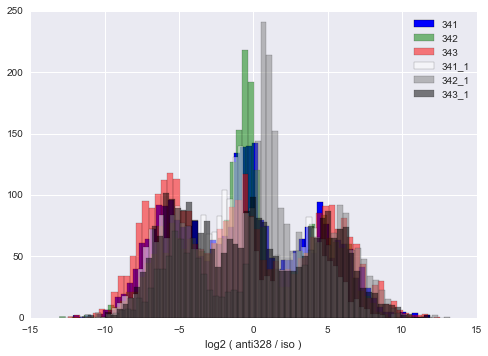

In [226]:
#ratio between anti and control
cp4['341_anti328_div_iso_0'][cp4['341_anti328_div_iso_0'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
cp4['342_anti328_div_iso_0'][cp4['342_anti328_div_iso_0'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
cp4['343_anti328_div_iso_0'][cp4['343_anti328_div_iso_0'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
cp4['341_anti328_div_iso_1'][cp4['341_anti328_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
cp4['342_anti328_div_iso_1'][cp4['342_anti328_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'grey', label = '342_1')
cp4['343_anti328_div_iso_1'][cp4['343_anti328_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'black', label = '343_1')
#cp4['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
#cp4['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
#cp4['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

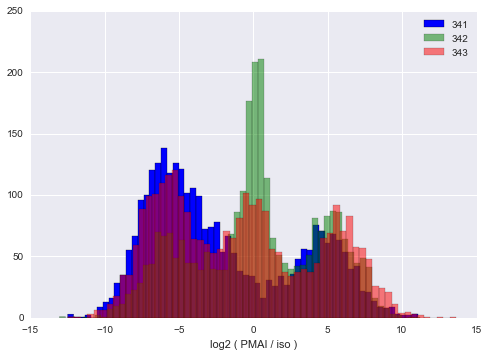

In [237]:
#ratio between pmai and control
cp4['341_pmai_div_iso_0'][cp4['341_pmai_div_iso_0'] <> 0].hist(bins=60, alpha = 1, color = 'b', label = '341')
cp4['342_pmai_div_iso_0'][cp4['342_pmai_div_iso_0'] <> 0].hist(bins=60, alpha = 0.5, color = 'g', label = '342')
cp4['343_pmai_div_iso_0'][cp4['343_pmai_div_iso_0'] <> 0].hist(bins=60, alpha = 0.5, color = 'r', label = '343')
#cp4['341_pmai_div_iso_1'][cp4['341_pmai_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'white', label = '341_1')
#cp4['342_pmai_div_iso_1'][cp4['342_pmai_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'grey', label = '342_1')
#cp4['343_pmai_div_iso_1'][cp4['343_pmai_div_iso_1'] <> 0].hist(bins=60, alpha = 0.5, color = 'black', label = '343_1')
#cp4['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
#cp4['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
#cp4['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('log2 ( pmai / iso )')
plt.legend()

In [362]:
"""#plt.scatter(np.log(cp2.iloc[cp3_chg.iloc[:,0].index]['m']), np.log(cp3_chg.iloc[:,0]))
#plt.title('{}, replicate {}'.format(*cp3_chg.columns[0]))
fig, axes = plt.subplots(12,1, figsize=(20, 100))
for idx in range(12):
    axes[idx].scatter(cp2.iloc[cp4.iloc[:,idx].index]['m'], np.log(cp4.iloc[:,idx]))
    axes[idx].set_xlabel('mass (m)', fontdict = {'fontsize':24})
    axes[idx].set_ylabel('log of ratio', fontdict = {'fontsize':24})
    axes[idx].set_title('{}, replicate {}'.format(*cp4.columns[idx]), fontdict = {'fontsize':24})
    axes[idx].axhline(c='black')""";

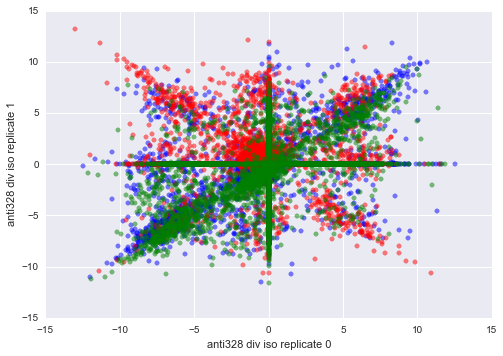

In [228]:
plt.scatter(cp4['343_anti328_div_iso_0'], cp4['343_anti328_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(cp4['342_anti328_div_iso_0'], cp4['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(cp4['341_anti328_div_iso_0'], cp4['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('anti328 div iso replicate 0')
plt.ylabel('anti328 div iso replicate 1')

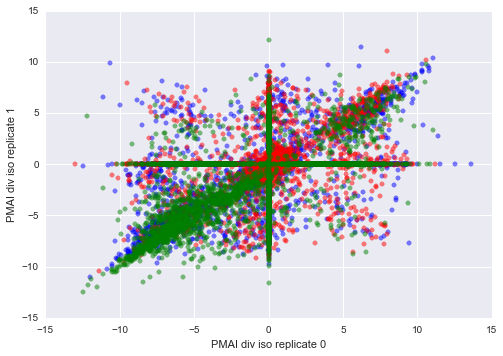

In [229]:
plt.scatter(cp4['343_pmai_div_iso_0'], cp4['343_pmai_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(cp4['342_pmai_div_iso_0'], cp4['342_pmai_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(cp4['341_pmai_div_iso_0'], cp4['341_pmai_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('pmai div iso replicate 0')
plt.ylabel('pmai div iso replicate 1')

In [368]:
cp2.columns

Index([               u'index',            u'File name',
                          u'#',                  u'm/z',
                          u'z',           u'scan start',
                   u'scan end',           u'scan range',
                       u'time',              u'matches',
                  u'amplitude',                u'score',
             u'amplitude_mean',        u'amplitude_std',
             u'norm_amplitude',                    u'm',
       u'scan range (seconds)',           u'time start',
                   u'time end',        u'agg_amplitude',
                  u'agg_index',              u'cluster',
               u'cluster_file',          u'cluster_sum'],
      dtype='object')

In [234]:
"""fig, axes = plt.subplots(4,1, figsize=(16, 24))
for idx in range(4):
    #IMPORTANT! Assumes that the cp2 name is 12 in length. 4 pmai, 4 or, 4 control
    #pmai vs control
    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']),c='orange', label = 'pmai')
    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx ]]['amplitude']), c='b', label = 'control')
    axes[idx].set_xlabel('mass (log)')
    axes[idx].set_xlabel('amplitude (log)')
    axes[idx].legend()
    axes[idx].set_title('Comparison of Amplitude by mass, replicate {}'.format(idx))
#plt.scatter((cp2[cp2['File name'] == cp2_name['m']), (cp2[cp2['File name'] == cp2_name['norm_amplitude']), alpha = 0.5, color = 'b')

#plt.scatter(cp2['342_anti328_div_iso_0'], cp4['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
#plt.scatter(cp2['341_anti328_div_iso_0'], cp4['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('m/z')
plt.ylabel('norm_amplitude')"""

"fig, axes = plt.subplots(4,1, figsize=(16, 24))\nfor idx in range(4):\n    #IMPORTANT! Assumes that the cp2 name is 12 in length. 4 pmai, 4 or, 4 control\n    #PMAI vs control\n    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']),c='orange', label = 'PMAI')\n    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx ]]['amplitude']), c='b', label = 'control')\n    axes[idx].set_xlabel('mass (log)')\n    axes[idx].set_xlabel('amplitude (log)')\n    axes[idx].legend()\n    axes[idx].set_title('Comparison of Amplitude by mass, replicate {}'.format(idx))\n#plt.scatter((cp2[cp2['File name'] == cp2_name['m']), (cp2[cp2['File name'] == cp2_name['norm_amplitude']), alpha = 0.5, color = 'b')\n\n#plt.scatter(cp2['342_anti328_div_iso_0'], cp4['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')\n#plt.scatter(cp2['341_anti328_div_iso_0'], cp4['341_

In [352]:
#unique rows that show up in cluster
ab = itertools.chain(*cluster)
unique_data = set(ab)

In [357]:
#These values should be the same. slight difference, but magnitude is small enough that i'm not investigating for now

print 'amplitude filtered for unique cluster values: {}'.format(cp2.loc[unique_data]['amplitude'].sum())
print 'aggregate amplitude: {}'.format(cp2['agg_amplitude'].sum())

amplitude filtered for unique cluster values: 192602638005
aggregate amplitude: 1.92175510855e+11


In [358]:
from collections import Counter
cluster_len = [len(row) for row in cp2['cluster']]
Counter(cluster_len)

Counter({0: 15454, 1: 11488, 2: 8389, 3: 6604, 4: 5861, 5: 5406, 6: 4657, 7: 3992, 8: 3493, 9: 3392, 10: 3178, 11: 2966, 13: 2602, 12: 2476, 14: 2327, 16: 2172, 23: 1830, 15: 1816, 17: 1791, 20: 1788, 21: 1755, 24: 1735, 32: 1657, 18: 1626, 19: 1571, 30: 1531, 26: 1497, 46: 1496, 41: 1455, 36: 1384, 22: 1340, 25: 1324, 42: 1296, 29: 1292, 28: 1269, 27: 1252, 45: 1236, 31: 1202, 37: 1191, 43: 1141, 53: 1118, 39: 1116, 47: 1084, 49: 1040, 44: 990, 33: 977, 38: 955, 34: 915, 40: 889, 48: 807, 54: 732, 35: 727, 70: 563, 51: 561, 50: 557, 63: 544, 62: 512, 58: 511, 64: 485, 57: 477, 106: 472, 56: 456, 55: 424, 81: 411, 60: 403, 83: 366, 67: 356, 117: 347, 65: 332, 52: 325, 71: 320, 77: 313, 75: 310, 107: 310, 68: 308, 59: 295, 69: 287, 82: 287, 72: 285, 105: 265, 76: 251, 61: 245, 94: 237, 78: 233, 147: 232, 84: 211, 86: 194, 178: 193, 89: 189, 74: 183, 79: 182, 66: 171, 102: 168, 129: 141, 104: 133, 126: 131, 123: 126, 93: 120, 119: 119, 130: 119, 80: 118, 134: 110, 125: 105, 85: 104, 127:

In [360]:
cp2_name = sorted(cp2['File name'].unique())

In [366]:
"""#blue = control
#red = or
#green = pmai
fig, axes = plt.subplots(4,3, figsize=(16, 24))
for idx in range(4):
    #IMPORTANT! Assumes that the cp2 name is 12 in length. 4 pmai, 4 or, 4 control
    #pmai vs control
    axes[idx, 0].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 4]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 4]]['amplitude']),c='b', label = 'control', alpha = 0.3)
    axes[idx, 0].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx]]['amplitude']), c='g', label = 'pmai', alpha = 0.3)
    axes[idx, 0].set_title('pmai vs control, trial {}'.format(idx))
    axes[idx, 0].set_xlabel('mass (log)')
    axes[idx, 0].set_ylabel('amplitude (log)')
    axes[idx, 0].legend()
    
    #or vs control
    axes[idx, 1].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 4]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 4]]['amplitude']),c='b', label = 'control', alpha = 0.3)
    axes[idx, 1].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']), c='r', label = 'or', alpha = 0.3)
    axes[idx, 1].set_title('or vs control, trial {}'.format(idx))
    axes[idx, 1].set_xlabel('mass (log)')
    axes[idx, 1].set_ylabel('amplitude (log)')
    axes[idx, 1].legend()
    
    #pmai vs or
    axes[idx, 2].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx]]['amplitude']),c='g', label = 'pmai', alpha = 0.3)
    axes[idx, 2].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']), c='r', label = 'or', alpha = 0.3)
    axes[idx, 2].set_title('pmai vs or, trial {}'.format(idx))
    axes[idx, 2].set_xlabel('mass (log)')
    axes[idx, 2].set_ylabel('amplitude (log)')
    axes[idx, 2].legend()""";

In [233]:
"""fig, axes = plt.subplots(4,1, figsize=(16, 24))
for idx in range(4):
    #IMPORTANT! Assumes that the cp2 name is 12 in length. 4 pmai, 4 or, 4 control
    #pmai vs control
    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']),c='orange', label = 'pmai')
    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx ]]['amplitude']), c='b', label = 'control')
    axes[idx].set_xlabel('mass (log)')
    axes[idx].set_xlabel('amplitude (log)')
    axes[idx].legend()
    axes[idx].set_title('Comparison of Amplitude by mass, replicate {}'.format(idx))"""

"fig, axes = plt.subplots(4,1, figsize=(16, 24))\nfor idx in range(4):\n    #IMPORTANT! Assumes that the cp2 name is 12 in length. 4 pmai, 4 or, 4 control\n    #PMAI vs control\n    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx + 8]]['amplitude']),c='orange', label = 'PMAI')\n    axes[idx].scatter( np.log(cp2[cp2['File name'] == cp2_name[idx]]['m']), np.log(cp2[cp2['File name'] == cp2_name[idx ]]['amplitude']), c='b', label = 'control')\n    axes[idx].set_xlabel('mass (log)')\n    axes[idx].set_xlabel('amplitude (log)')\n    axes[idx].legend()\n    axes[idx].set_title('Comparison of Amplitude by mass, replicate {}'.format(idx))"

In [ ]:
### CHART PATTERN CHYMO ###

In [159]:
cp_chymo = pd.read_excel((folder + chartpattern_chymo),sheetname='Sheet1')

In [177]:
file_amplitude = cp_chymo.groupby('File name').amplitude.agg(['mean', 'std']).reset_index()
file_amplitude.columns = ['File name','amplitude_mean','amplitude_std']

cp1_chymo = cp_chymo.merge(file_amplitude, on='File name', how='left')
cp1_chymo['norm_amplitude'] = (cp1_chymo['amplitude'] - cp1_chymo['amplitude_mean'] / cp1_chymo['amplitude_std'])


In [179]:
cp2_chymo = cp1_chymo.copy()
cp2_chymo = cp2_chymo.sort_values('score', ascending=False)
cp2_chymo['m'] = cp2_chymo['m/z'] * cp2_chymo['z']

#Christina's set conversion from scanrange to seconds
scanrange_to_time = 0.5
cp2_chymo['scan range (seconds)'] = scanrange_to_time * cp2_chymo['scan range']
cp2_chymo['time start'] = cp2_chymo['time'] - cp2_chymo['scan range (seconds)']
cp2_chymo['time end'] = cp2_chymo['time'] + cp2_chymo['scan range (seconds)']

In [181]:
cp2_chymo.head()

,File name,#,m/z,z,scan range,Unnamed: 5,scans,time,matches,amplitude,score,amplitude_mean,amplitude_std,norm_amplitude,m,scan range (seconds),time start,time end
49555,342_iso_1,1,507.57,3,5136,5210,75,3087,14,5967983,113.4,1.987847e+06,8.096339e+06,5.967983e+06,1522.71,2568.0,519.0,5655.0
62722,341_anti328_1,1,771.34,3,7986,8190,205,5195,40,6942154,112.5,7.542293e+05,2.655431e+06,6.942154e+06,2314.02,3993.0,1202.0,9188.0
16393,343_PMAI_1,1,716.31,3,3636,3720,85,1739,16,1862008,112.2,6.725531e+05,2.537662e+06,1.862008e+06,2148.93,1818.0,-79.0,3557.0
7670,341_iso_1,1,870.36,2,6391,6625,235,3957,44,18569375,111.2,1.160908e+06,4.032068e+06,1.856937e+07,1740.72,3195.5,761.5,7152.5
33367,342_PMAI_1,1,507.57,3,5366,5620,255,2897,50,7972117,110.6,5.625797e+05,1.769175e+06,7.972117e+06,1522.71,2683.0,214.0,5580.0


In [ ]:
(overall mz - row mz ) if within limit


In [258]:
mz_limit = 0.01
score_floor = 0
cluster = []
cluster_file = []
agg_amplitude = np.zeros(cp2_chymo.shape[0])
agg_index = np.zeros(cp2_chymo.shape[0])
agg_index.fill(-1)
exceptions = []

for row in range(cp2_chymo.shape[0]):
    if row % 5000 == 0:
        print 'processing row {}'.format(row)
    mz_mask = np.abs(cp2_chymo['m/z'] - cp2_chymo.loc[row, 'm/z']) <= mz_limit
    z_mask = cp2_chymo['z'] == cp2_chymo.loc[row, 'z']
    scan_mask = (cp2_chymo['time start'] <= cp2_chymo.loc[row, 'time end']) | (cp2_chymo['time end'] >= cp2_chymo.loc[row, 'time start'])
    score_mask = cp2_chymo['score'] >= score_floor
    file_mask = cp2_chymo['File name'] == cp2_chymo.loc[row, 'File name']
    
    cluster_mask = (mz_mask & z_mask & scan_mask & score_mask)
    cluster_file_mask = (mz_mask & z_mask & scan_mask & score_mask & file_mask)
    
    cluster.append(cp2_chymo.index[cluster_mask].tolist())
    cluster_file.append(cp2_chymo.index[cluster_file_mask].tolist())
    
    #agg_index only calculates based off of cluster, which is conditioned from the 4 masks above
    if len(cluster_file[row]) > 0:
        if cluster_file[row][0] == row:
            agg_index[row] = cluster[-1][0]
            agg_amplitude[row] = cp2_chymo.iloc[cluster_file[row],'norm_amplitude'].sum()
    else:
        exceptions.append(row)
        #print cp2.loc[row, 'm/z'], cp2.loc[row, 'z'], cp2.loc[row, 'time end'], cp2.loc[row, 'time start']

processing row 0
processing row 1000
processing row 2000
processing row 3000
processing row 4000
processing row 5000
processing row 6000
processing row 7000
processing row 8000
processing row 9000
processing row 10000
processing row 11000
processing row 12000
processing row 13000
processing row 14000
processing row 15000
processing row 16000
processing row 17000
processing row 18000
processing row 19000
processing row 20000
processing row 21000
processing row 22000
processing row 23000
processing row 24000
processing row 25000
processing row 26000
processing row 27000
processing row 28000
processing row 29000
processing row 30000
processing row 31000
processing row 32000
processing row 33000
processing row 34000
processing row 35000
processing row 36000
processing row 37000
processing row 38000
processing row 39000
processing row 40000
processing row 41000
processing row 42000
processing row 43000
processing row 44000
processing row 45000
processing row 46000
processing row 47000
proce

In [275]:
cp2_chymo['agg_amplitude'] = agg_amplitude
cp2_chymo['agg_index'] = agg_index
cp2_chymo['cluster'] = cluster
cp2_chymo['cluster_file'] = cluster_file
#cp2['File name'].astype(int);

In [276]:
#checking that the cluster groups are consistent
#if row 10 cluster contains [10,21,48], that row 21 is also [10,21,48]
#found that it's largely true, 3160 of 3311 clusters are completely identical
#for non-identical, it's still not a major problem because comparisons of pmai, or, control are still valid within the group
cp2_chymo['cluster_sum'] = [sum(row) for row in cp2_chymo['cluster']]


In [569]:
cp2test_chymo = cp2_chymo[cp2_chymo['score'] > 10]

In [570]:
cp2_pivot_chymo = cp2test_chymo.pivot_table(values='amplitude', index='agg_index', columns=['File name'],aggfunc='sum')

In [571]:
#nan are undetectable amplitudes. setting to a minimum threshhold of 10,000
min_amplitude = 10000

cp3_pivot_chymo = cp2_pivot_chymo.fillna(min_amplitude)

In [572]:
#Raw data missing values is 0. replace zero with one to avoid divison by zero

cp3_pivot_chymo['341_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['341_anti328_0']) - np.log2(cp3_pivot_chymo['341_iso0'] )
cp3_pivot_chymo['341_pmai_div_iso_0'] = np.log2(cp3_pivot_chymo['341_pmai_0']) -  np.log2(cp3_pivot_chymo['341_iso0'])
cp3_pivot_chymo['341_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['341_anti328_1']) - np.log2(cp3_pivot_chymo['341_iso1'] )
cp3_pivot_chymo['341_pmai_div_iso_1'] = np.log2(cp3_pivot_chymo['341_pmai_1']) - np.log2(cp3_pivot_chymo['341_iso1'])

cp3_pivot_chymo['342_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['342_anti328_0']) - np.log2(cp3_pivot_chymo['342_iso_0'] )
cp3_pivot_chymo['342_pmai_div_iso_0'] = np.log2(cp3_pivot_chymo['342_pmai_0']) - np.log2(cp3_pivot_chymo['342_iso_0'])
cp3_pivot_chymo['342_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['342_anti328_1']) - np.log2(cp3_pivot_chymo['342_iso_1'] )
cp3_pivot_chymo['342_pmai_div_iso_1'] = np.log2(cp3_pivot_chymo['342_pmai_1']) - np.log2(cp3_pivot_chymo['342_iso_1'])

cp3_pivot_chymo['343_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['342_unlabeled_0']) - np.log2(cp3_pivot_chymo['343_iso_0'] )
cp3_pivot_chymo['343_pmai_div_iso_0'] = np.log2(cp3_pivot_chymo['343_pmai_0']) - np.log2(cp3_pivot_chymo['343_iso_0'])
cp3_pivot_chymo['343_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['342_unlabeled_1']) - np.log2(cp3_pivot_chymo['343_iso_1'] )
cp3_pivot_chymo['343_pmai_div_iso_1'] = np.log2(cp3_pivot_chymo['343_pmai_1']) - np.log2(cp3_pivot_chymo['343_iso_1'])

cp3_pivot_chymo['15m_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['15m_anti328_0']) - np.log2(cp3_pivot_chymo['15m_iso_0'] )
cp3_pivot_chymo['15m_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['15m_anti328_1']) - np.log2(cp3_pivot_chymo['15m_iso_1'] )
cp3_pivot_chymo['6h_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['6h_anti328_0']) - np.log2(cp3_pivot_chymo['6h_iso_0'] )
cp3_pivot_chymo['6h_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['6h_anti328_1']) - np.log2(cp3_pivot_chymo['6h_iso_1'] )
cp3_pivot_chymo['18h_anti328_div_iso_0'] =  np.log2(cp3_pivot_chymo['18h_anti328_0']) - np.log2(cp3_pivot_chymo['18h_iso_0'] )
cp3_pivot_chymo['18h_anti328_div_iso_1'] =  np.log2(cp3_pivot_chymo['18h_anti328_1']) - np.log2(cp3_pivot_chymo['18h_iso_1'] )

In [573]:
cp3a_pivot_chymo = cp3_pivot_chymo

cp3a_pivot_chymo.mean().head()

File name
15m_anti328_0            577612.715092
15m_anti328_1            208263.445295
15m_iso_0                530048.603869
15m_iso_1                178727.286319
18h_anti328_0            423424.175499
18h_anti328_1            136863.570623
18h_iso_0                458136.678320
18h_iso_1                218156.586137
341_PMAI_0               109607.724058
341_PMAI_1                50511.663208
341_anti328_0            204368.389784
341_anti328_1            271510.479246
341_iso0                 658130.209954
341_iso1                 410005.191316
342_PMAI_0               264728.314225
342_PMAI_1               164310.071731
342_anti328_0            595173.900766
342_anti328_1            652011.456881
342_iso_0                745940.140238
342_iso_1                742349.617369
342_unlabeled_0          410488.205420
342_unlabeled_1          340430.233427
343_PMAI_0               331158.309591
343_PMAI_1               193406.707032
343_anti328_0             40542.661797
343_anti328_1  

In [564]:
cp3_pivot_chymo.columns[31:]

Index([u'341_anti328_div_iso_0', u'341_PMAI_div_iso_0',
       u'341_anti328_div_iso_1', u'341_PMAI_div_iso_1',
       u'342_anti328_div_iso_0', u'342_PMAI_div_iso_0',
       u'342_anti328_div_iso_1', u'342_PMAI_div_iso_1',
       u'343_anti328_div_iso_0', u'343_PMAI_div_iso_0',
       u'343_anti328_div_iso_1', u'343_PMAI_div_iso_1',
       u'15m_anti328_div_iso_0', u'15m_anti328_div_iso_1',
       u'6h_anti328_div_iso_0', u'6h_anti328_div_iso_1',
       u'18h_anti328_div_iso_0', u'18h_anti328_div_iso_1'],
      dtype='object', name=u'File name')

In [565]:
# Isolate columns only from replicates 341, 342, 343
cp4_chymo = cp3_pivot_chymo[cp3_pivot_chymo.columns[31:]]

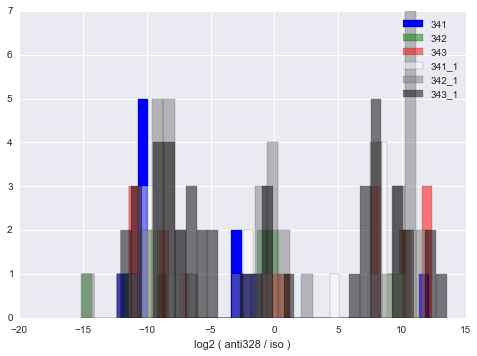

In [566]:
#ratio between anti and control
cp4_chymo['341_anti328_div_iso_0'][cp4_chymo['341_anti328_div_iso_0'] <> 0].hist(bins=30, alpha = 1, color = 'b', label = '341')
cp4_chymo['342_anti328_div_iso_0'][cp4_chymo['342_anti328_div_iso_0'] <> 0].hist(bins=30, alpha = 0.5, color = 'g', label = '342')
cp4_chymo['343_anti328_div_iso_0'][cp4_chymo['343_anti328_div_iso_0'] <> 0].hist(bins=30, alpha = 0.5, color = 'r', label = '343')
cp4_chymo['341_anti328_div_iso_1'][cp4_chymo['341_anti328_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'white', label = '341_1')
cp4_chymo['342_anti328_div_iso_1'][cp4_chymo['342_anti328_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'grey', label = '342_1')
cp4_chymo['343_anti328_div_iso_1'][cp4_chymo['343_anti328_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'black', label = '343_1')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

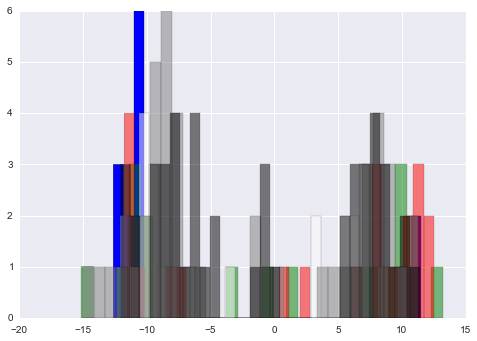

In [567]:
#ratio between pmai and control
cp4_chymo['341_pmai_div_iso_0'][cp4_chymo['341_pmai_div_iso_0'] <> 0].hist(bins=30, alpha = 1, color = 'b', label = '341')
cp4_chymo['342_pmai_div_iso_0'][cp4_chymo['342_pmai_div_iso_0'] <> 0].hist(bins=30, alpha = 0.5, color = 'g', label = '342')
cp4_chymo['343_pmai_div_iso_0'][cp4_chymo['343_pmai_div_iso_0'] <> 0].hist(bins=30, alpha = 0.5, color = 'r', label = '343')
cp4_chymo['341_pmai_div_iso_1'][cp4_chymo['341_pmai_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'white', label = '341_1')
cp4_chymo['342_pmai_div_iso_1'][cp4_chymo['342_pmai_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'grey', label = '342_1')
cp4_chymo['343_pmai_div_iso_1'][cp4_chymo['343_pmai_div_iso_1'] <> 0].hist(bins=30, alpha = 0.5, color = 'black', label = '343_1')


In [568]:
cp4_chymo['15m_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'white', label = '15m')
cp4_chymo['6h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'grey', label = '6h')
cp4_chymo['18h_anti328_div_iso'].hist(bins=60, alpha = 0.5, color = 'black', label = '18h')
plt.xlabel('log2 ( anti328 / iso )')
plt.legend()

KeyError: '15m_anti328_div_iso'

In [ ]:
plt.scatter(cp4['343_anti328_div_iso_0'], cp4['343_anti328_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(cp4['342_anti328_div_iso_0'], cp4['342_anti328_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(cp4['341_anti328_div_iso_0'], cp4['341_anti328_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('anti328 div iso replicate 0')
plt.ylabel('anti328 div iso replicate 1')

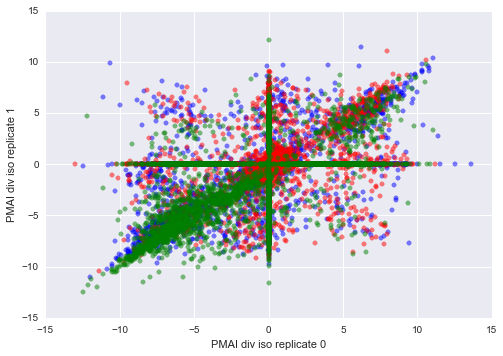

In [270]:
plt.scatter(cp4['343_pmai_div_iso_0'], cp4['343_pmai_div_iso_1'], alpha = 0.5, color = 'b')
plt.scatter(cp4['342_pmai_div_iso_0'], cp4['342_pmai_div_iso_1'], alpha = 0.5, color = 'r')
plt.scatter(cp4['341_pmai_div_iso_0'], cp4['341_pmai_div_iso_1'], alpha = 0.5, color = 'g')
plt.xlabel('pmai div iso replicate 0')
plt.ylabel('pmai div iso replicate 1')